<span style="color:red">
To get this notebook running, please install: <br> 
1. sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config <br>
2. pip install pygraphviz
</span>

In [1]:
import sys
import os

repo_path = os.path.sep.join(os.getcwd().split(os.path.sep)[:-3])
sys.path.append(repo_path)
# resolves problem for Niklas os.chdir(repo_path)
#%cd /home/schilcherj/master/deepClustering/LMU_Master_Practical_SoSe24/
%cd ../../..


/home/schilcherj/master/deepClustering/LMU_Master_Practical_SoSe24


/home/schilcherj/master/deepClustering/deepClustEnv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from clustpy.deep.autoencoders import FeedforwardAutoencoder
from practical.DeepClustering.DeepECT.evaluation_pipeline import DatasetType, evaluate_multiple_seeds, calculate_flat_mean_for_multiple_seeds, calculate_hierarchical_mean_for_multiple_seeds
import torch
import matplotlib.pyplot as plt
from clustpy.data import load_fmnist, load_mnist, load_usps
import random
import numpy as np
from practical.DeepClustering.DeepECT.evaluation_pipeline import get_custom_dataloader_augmentations, DatasetType, AutoencoderType, pretraining
from practical.DeepClustering.DeepECT.deepect import DeepECT
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import networkx as nx
from sklearn.utils import Bunch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import minmax_scale

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preliminary setting

## Visualizing pretrained autoencoders

In [3]:
def visualize_peformance_AE(param_path_autoencoder: str, autoencoder_class: torch.nn.Module, dataset: Bunch, image_size: tuple, number_samples: int, seed: int = None):

    if seed is not None and type(seed) == int:
        random.seed(seed)

    autoencoder = pretraining(autoencoder_class, param_path_autoencoder, dataset, seed, 10)
    samples = dataset["data"]
    labels = dataset["target"]
    fig, ax = plt.subplots(2, number_samples)
    fig.tight_layout()
    ax = ax.flatten()
    for i, index in enumerate(
        sorted(random.sample(range(samples.shape[0]), number_samples))
    ):
        img = samples[index]
        if img.ndim == 1:
            img = np.expand_dims(img,0)
        img_rec = autoencoder.decode(autoencoder.encode(torch.from_numpy(img))).detach().numpy()
        ax[i].imshow(img.reshape(image_size[0],image_size[1]), cmap='gray')
        ax[i+number_samples].imshow(img_rec.reshape(image_size[0],image_size[1]), cmap='gray')
        ax[i].set_title(f'original')
        ax[i+number_samples].set_title(f'reconstructed')
        ax[i].set_axis_off()
        ax[i+number_samples].set_axis_off()

    embeddings = autoencoder.encode(torch.from_numpy(samples)).detach().clone().numpy()

    # PCA of embedded space
    plt.figure()
    pca = PCA(n_components=2)
    projected_data = pca.fit_transform(embeddings)
    plt.scatter(projected_data[:, 0], projected_data[:, 1], c=labels, cmap='viridis')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of embedded space')
    if dataset["dataset_name"] == 'FashionMNIST':
        cbar = plt.colorbar()
        cbar.set_ticks(np.arange(10))
        cbar.set_ticklabels(["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"])
        
    else:
        plt.colorbar(label='Digit')
    plt.show()

    # TSNE from embedded space
    plt.figure()
    projected_data = TSNE(n_components=2, perplexity=40, n_iter=500).fit_transform(embeddings)
    plt.scatter(projected_data[:, 0], projected_data[:, 1], c=labels, cmap='viridis')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.title('t-SNE of embedded space')
    if dataset["dataset_name"] == 'FashionMNIST':
        cbar = plt.colorbar()
        cbar.set_ticks(np.arange(10))
        cbar.set_ticklabels(["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"])
        
    else:
        plt.colorbar(label='Digit')
    plt.show()

##### MNIST

Autoencoder parameters loaded from file.


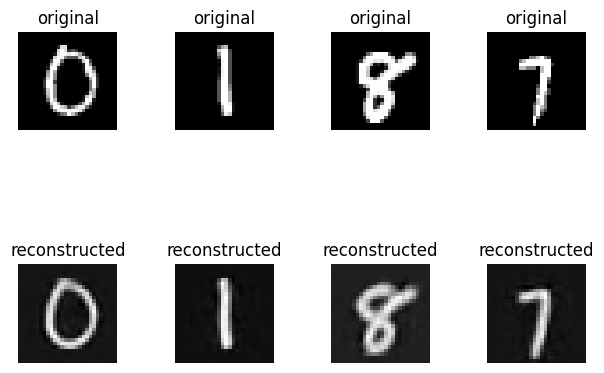

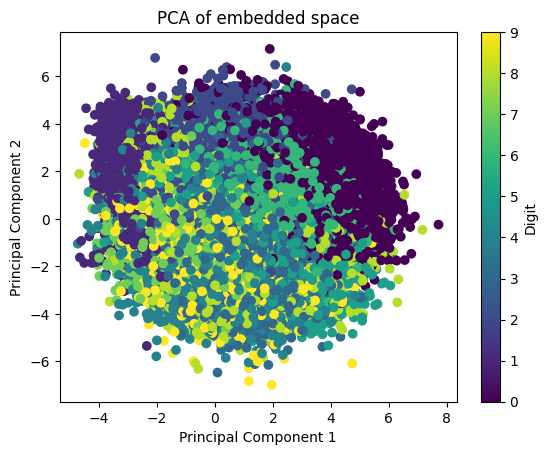

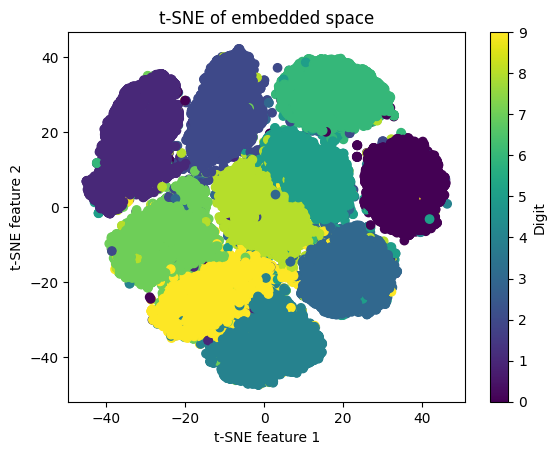

Autoencoder parameters loaded from file.


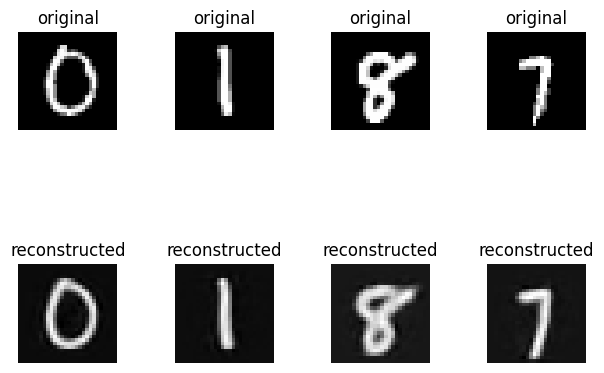

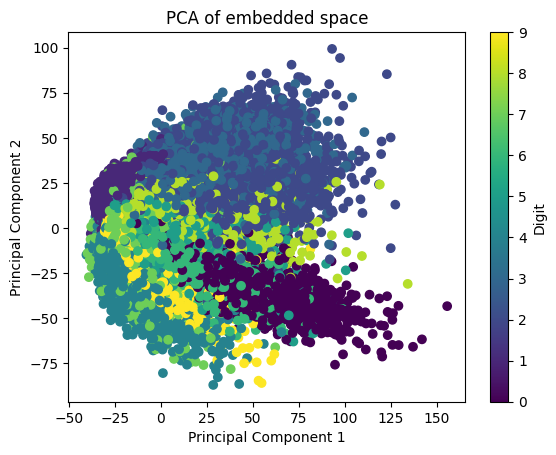

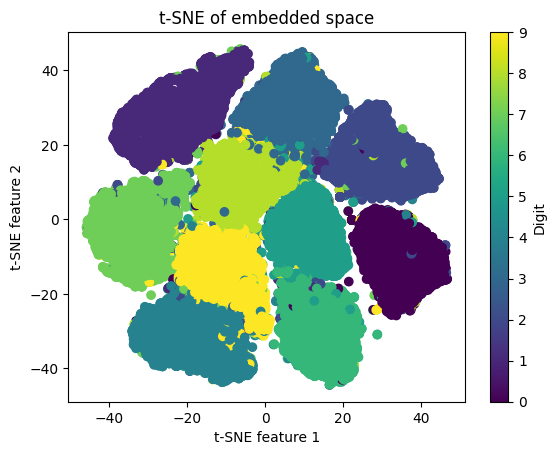

(None, None)

In [4]:
dataset = load_mnist()
dataset["data"] = dataset["data"] * 0.02
data = dataset["data"]
labels = dataset["target"]
visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/pretrained_autoencoders/MNIST_autoencoder_10_pretrained_21.pt",
    AutoencoderType.CLUSTPY_STANDARD,
    dataset,
    (28, 28),
    4,
    seed=21,
), visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/pretrained_autoencoders/MNIST_stacked_ae_10_pretrained_21.pt",
    AutoencoderType.DEEPECT_STACKED_AE,
    dataset,
    (28, 28),
    4,
    seed=21,
)

##### USPS

Autoencoder parameters loaded from file.


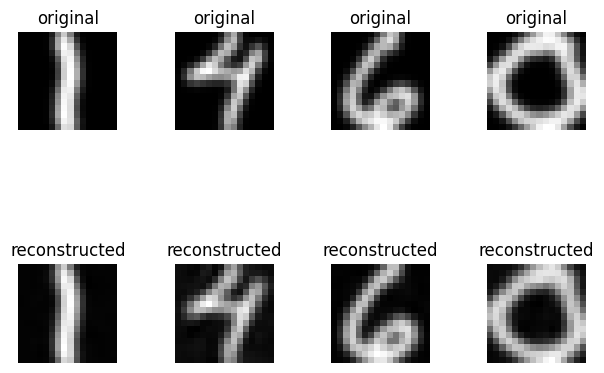

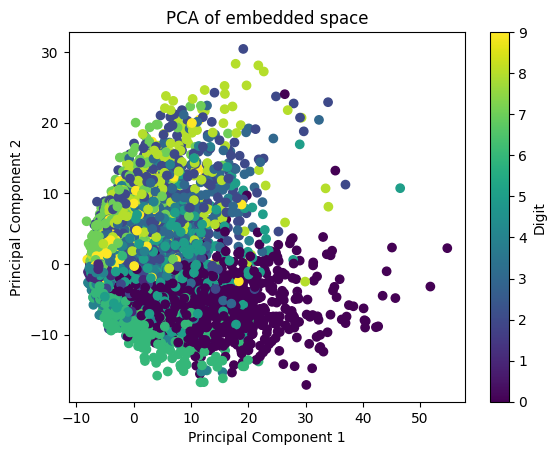

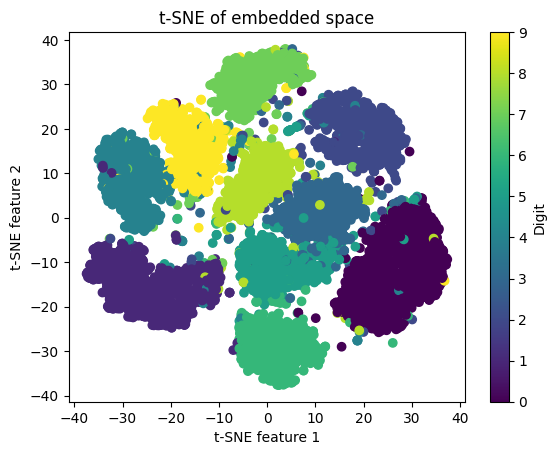

In [6]:
dataset = load_usps()
dataset["data"] = np.asarray(minmax_scale(dataset["data"], feature_range=(-1, 1)),dtype=np.float32)
data = dataset["data"]
labels = dataset["target"]
# visualize_peformance_AE(
#     "practical/DeepClustering/DeepECT/pretrained_autoencoders/USPS_autoencoder_10_pretrained_21.pth",
#     AutoencoderType.CLUSTPY_STANDARD,
#     dataset,
#     (16, 16),
#     4,
#     seed=21,
# ), 
visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/pretrained_autoencoders/USPS_stacked_ae_10_pretrained_21.pt",
    AutoencoderType.DEEPECT_STACKED_AE,
    dataset,
    (16, 16),
    4,
    seed=21,
)

##### FMNIST

Autoencoder parameters loaded from file.


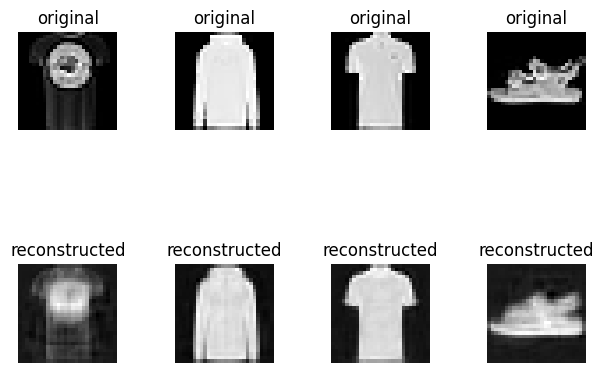

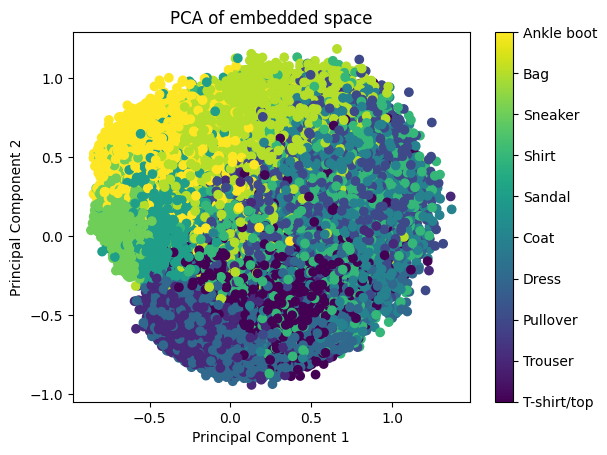

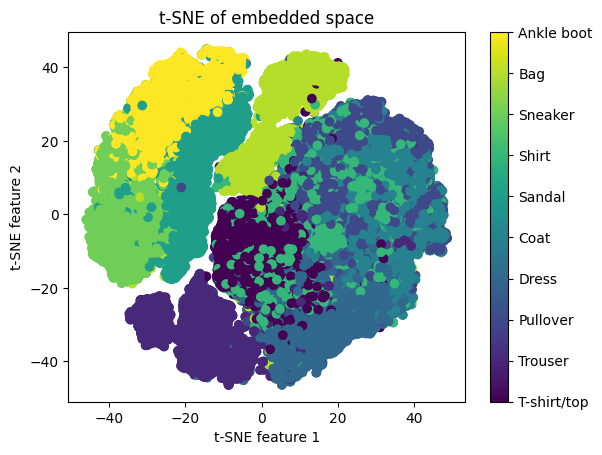

Autoencoder parameters loaded from file.


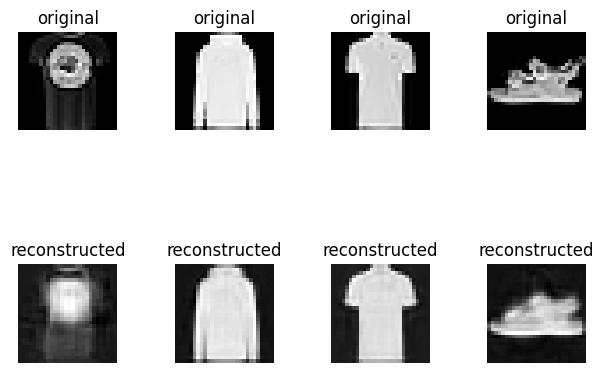

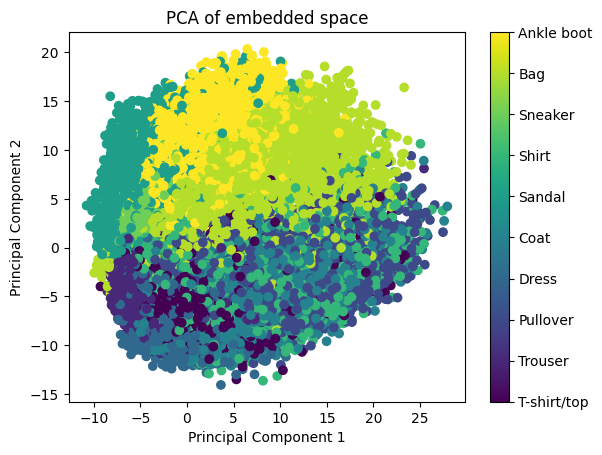

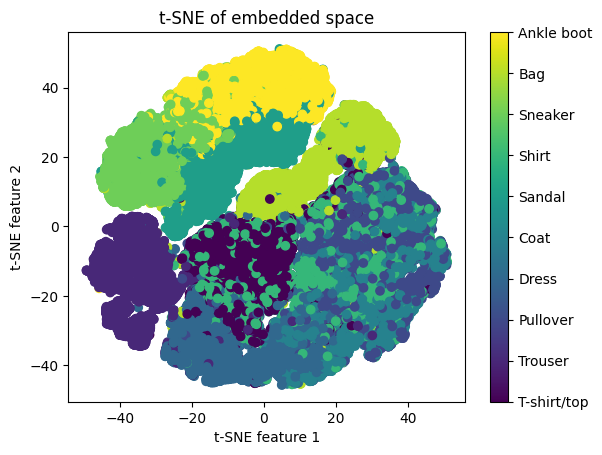

(None, None)

In [7]:
dataset = load_fmnist()
dataset["data"] = dataset["data"] / 255.0
data = dataset["data"] 
labels = dataset["target"]
visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/pretrained_autoencoders/FashionMNIST_autoencoder_10_pretrained_21.pt",
    AutoencoderType.CLUSTPY_STANDARD,
    dataset,
    (28, 28),
    4,
    seed=21,
), visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/pretrained_autoencoders/FashionMNIST_stacked_ae_10_pretrained_21.pt",
    AutoencoderType.DEEPECT_STACKED_AE,
    dataset,
    (28, 28),
    4,
    seed=21,
)

## Visualization of augmented data

In [3]:
def show_augmented_data(data: np.ndarray, dataset_type: DatasetType, image_size: tuple, number_samples: int):

    (trainloader, _) = get_custom_dataloader_augmentations(data, dataset_type)
    idx, M, M_aug = next(iter(trainloader))

    fig, ax = plt.subplots(2, number_samples)
    fig.tight_layout()
    ax = ax.flatten()
    for i, index in enumerate(sorted(random.sample(range(M.shape[0]),number_samples))):
        img = M[index]
        img_aug = M_aug[index]
        if img.ndim == 1:
            img = np.expand_dims(img,0)
        ax[i].imshow(img.reshape(image_size[0],image_size[1]), cmap='gray')
        ax[i+number_samples].imshow(img_aug.reshape(image_size[0],image_size[1]), cmap='gray')
        ax[i].set_title(f'original')
        ax[i+number_samples].set_title(f'augmented')
        ax[i].set_axis_off()
        ax[i+number_samples].set_axis_off()
        

##### MNIST

5.1


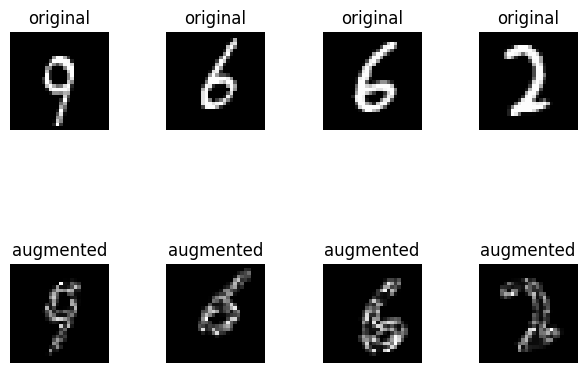

In [4]:
# dataset = load_mnist()
# data = dataset["data"] / 255
# labels = dataset["target"]

#data from paper will be normalized to [0, 5.1], because DEC does this as well

from scipy import io
with open("./practical/DeepClustering/DeepECT/mnist-original.mat", 'rb') as matlab_file:
        matlab_dict = io.loadmat(matlab_file, struct_as_record=True)
data = matlab_dict['data'].T.astype(np.float32)
label = np.squeeze(matlab_dict['label'], 0).astype(np.int32)
data = data * 0.02  
show_augmented_data(data, DatasetType.MNIST, (28,28), 4)

In [4]:
flat_mnist_multiple_seeds_clustpy_ae, hierarchical_mnist_multiple_seeds_clustpy_ae = evaluate_multiple_seeds(
    autoencoder_type=AutoencoderType.CLUSTPY_STANDARD,
    dataset_type=DatasetType.MNIST,
    seeds=[2])

-------------------------------------------Run: MNIST_CLUSTPY_STANDARD_10_2
new mnist
Autoencoder parameters loaded from file.
fitting DeepECT+AUG...
cpu


Fit:   0%|          | 1/40000 [00:02<25:31:50,  2.30s/it]

1 - moving averages: dc_loss: 2.1871140003204346 nc_loss: 3.329777479171753 rec_loss: 0.39065082371234894 rec_loss_aug: 2.055785655975342 total_loss: 7.963328123092651


Fit:   0%|          | 2/40000 [00:03<18:34:08,  1.67s/it]

2 - moving averages: dc_loss: 1.6089627742767334 nc_loss: 2.4780569672584534 rec_loss: 0.297169528901577 rec_loss_aug: 1.1754340529441833 total_loss: 5.55962336063385


Fit:   0%|          | 3/40000 [00:04<17:03:52,  1.54s/it]

3 - moving averages: dc_loss: 1.4077828725179036 nc_loss: 2.2019046942392984 rec_loss: 0.2630350838104884 rec_loss_aug: 0.8597784489393234 total_loss: 4.732501109441121


Fit:   0%|          | 4/40000 [00:06<16:44:09,  1.51s/it]

4 - moving averages: dc_loss: 1.3127621412277222 nc_loss: 2.056299537420273 rec_loss: 0.24996189028024673 rec_loss_aug: 0.6826002635061741 total_loss: 4.3016237616539


Fit:   0%|          | 5/40000 [00:07<15:37:55,  1.41s/it]

5 - moving averages: dc_loss: 1.241238784790039 nc_loss: 1.9718491792678834 rec_loss: 0.24127794206142425 rec_loss_aug: 0.5694123491644859 total_loss: 4.023778200149536


Fit:   0%|          | 6/40000 [00:08<15:28:59,  1.39s/it]

6 - moving averages: dc_loss: 1.1963732242584229 nc_loss: 1.9256415168444316 rec_loss: 0.23403187344471613 rec_loss_aug: 0.4914187292257945 total_loss: 3.8474653164545694


Fit:   0%|          | 7/40000 [00:10<15:17:54,  1.38s/it]

7 - moving averages: dc_loss: 1.1680783033370972 nc_loss: 1.897545507975987 rec_loss: 0.2320135874407632 rec_loss_aug: 0.4359509955559458 total_loss: 3.73358838898795


Fit:   0%|          | 8/40000 [00:11<15:24:12,  1.39s/it]

8 - moving averages: dc_loss: 1.1540729254484177 nc_loss: 1.8703203201293945 rec_loss: 0.23120319284498692 rec_loss_aug: 0.39157677441835403 total_loss: 3.647173196077347


Fit:   0%|          | 9/40000 [00:13<15:34:48,  1.40s/it]

9 - moving averages: dc_loss: 1.1355559560987685 nc_loss: 1.8519113858540852 rec_loss: 0.23025894496175978 rec_loss_aug: 0.35875506119595635 total_loss: 3.5764813158247204


Fit:   0%|          | 11/40000 [00:14<9:51:57,  1.13it/s] 

10 - moving averages: dc_loss: 1.1174006402492522 nc_loss: 1.8340787410736084 rec_loss: 0.2275855839252472 rec_loss_aug: 0.3301295340061188 total_loss: 3.5091944694519044


Fit:   0%|          | 101/40000 [00:28<1:40:12,  6.64it/s]

100 - moving averages: dc_loss: 0.8537409156560898 nc_loss: 1.8183956372737884 rec_loss: 0.21998653665184975 rec_loss_aug: 0.06838775975629688 total_loss: 2.9605108380317686


Fit:   1%|          | 201/40000 [00:43<1:42:51,  6.45it/s]

200 - moving averages: dc_loss: 0.7645927143096923 nc_loss: 1.88916208922863 rec_loss: 0.223436663672328 rec_loss_aug: 0.045072224400937555 total_loss: 2.922263685464859


Fit:   1%|          | 301/40000 [01:11<1:38:16,  6.73it/s] 

300 - moving averages: dc_loss: 0.7114941291014354 nc_loss: 1.9139474046230316 rec_loss: 0.2261252367993196 rec_loss_aug: 0.03664896215622624 total_loss: 2.8882157333691914


Fit:   1%|          | 401/40000 [01:26<1:40:09,  6.59it/s]

400 - moving averages: dc_loss: 0.6651774670928716 nc_loss: 1.921201717853546 rec_loss: 0.22880500335246323 rec_loss_aug: 0.032408088324591515 total_loss: 2.8475922787189485


Fit:   1%|▏         | 501/40000 [02:46<215:48:34, 19.67s/it]

Leaf assignments: 53278
Tree size after growing: 5, leaf nodes: 3
500 - moving averages: dc_loss: 0.6162650067210197 nc_loss: 1.9115037546157836 rec_loss: 0.23215018954873085 rec_loss_aug: 0.02983455789834261 total_loss: 2.7897535076141358


Fit:   2%|▏         | 601/40000 [03:13<1:36:15,  6.82it/s]  

600 - moving averages: dc_loss: 0.5803039499620597 nc_loss: 1.9002786658207576 rec_loss: 0.23227696344256402 rec_loss_aug: 0.028169930183018246 total_loss: 2.741029504934947


Fit:   2%|▏         | 701/40000 [03:28<1:39:31,  6.58it/s]

700 - moving averages: dc_loss: 0.5384945404103824 nc_loss: 1.9291886854171754 rec_loss: 0.23096705291952405 rec_loss_aug: 0.026924230057213987 total_loss: 2.7255745097569055


Fit:   2%|▏         | 801/40000 [03:43<1:53:36,  5.75it/s]

800 - moving averages: dc_loss: 0.5005594752170146 nc_loss: 1.971701773405075 rec_loss: 0.2297523363120854 rec_loss_aug: 0.02595901775639504 total_loss: 2.727972602546215


Fit:   2%|▏         | 901/40000 [04:16<1:46:08,  6.14it/s] 

900 - moving averages: dc_loss: 0.4681013629006015 nc_loss: 2.013538288275401 rec_loss: 0.22812346282932494 rec_loss_aug: 0.025186104586140977 total_loss: 2.7349492208162944


Fit:   2%|▎         | 1000/40000 [04:32<1:36:12,  6.76it/s]

Leaf assignments: 22305
Tree size after growing: 7, leaf nodes: 4
1000 - moving averages: dc_loss: 0.44091368490457533 nc_loss: 2.0524043662548066 rec_loss: 0.22673874635994434 rec_loss_aug: 0.02457016569375992 total_loss: 2.744626965999603


Fit:   3%|▎         | 1100/40000 [06:05<11:01:23,  1.02s/it] 

1100 - moving averages: dc_loss: 0.4186121563342485 nc_loss: 2.084296291958202 rec_loss: 0.2248701545731588 rec_loss_aug: 0.024064278182658282 total_loss: 2.751842882633209


Fit:   3%|▎         | 1201/40000 [06:27<1:34:17,  6.86it/s] 

1200 - moving averages: dc_loss: 0.39868027249972027 nc_loss: 2.1085806026061378 rec_loss: 0.2227538891384999 rec_loss_aug: 0.023632200594681005 total_loss: 2.753646967212359


Fit:   3%|▎         | 1301/40000 [06:43<1:34:13,  6.85it/s]

1300 - moving averages: dc_loss: 0.3807998137978407 nc_loss: 2.1284149478032037 rec_loss: 0.22082833983577216 rec_loss_aug: 0.023271018551805845 total_loss: 2.7533141213196974


Fit:   4%|▎         | 1401/40000 [07:10<1:37:36,  6.59it/s] 

1400 - moving averages: dc_loss: 0.3644618795173509 nc_loss: 2.144177051952907 rec_loss: 0.2190160798281431 rec_loss_aug: 0.0229472751809018 total_loss: 2.75060228739466


Fit:   4%|▍         | 1501/40000 [08:36<228:53:51, 21.40s/it]

Leaf assignments: 26665
Tree size after growing: 9, leaf nodes: 5
1500 - moving averages: dc_loss: 0.3499091369360685 nc_loss: 2.1560422523816425 rec_loss: 0.21731389364600182 rec_loss_aug: 0.022666126273572444 total_loss: 2.745931409041087


Fit:   4%|▍         | 1601/40000 [08:51<1:36:55,  6.60it/s]  

1600 - moving averages: dc_loss: 0.33709793971385804 nc_loss: 2.163459075391293 rec_loss: 0.21579042254947126 rec_loss_aug: 0.0224198618135415 total_loss: 2.738767299503088


Fit:   4%|▍         | 1701/40000 [09:19<1:35:39,  6.67it/s] 

1700 - moving averages: dc_loss: 0.3249845878341619 nc_loss: 2.169841399052564 rec_loss: 0.21417468378649038 rec_loss_aug: 0.022193905361654127 total_loss: 2.731194575253655


Fit:   5%|▍         | 1801/40000 [09:36<1:51:09,  5.73it/s]

1800 - moving averages: dc_loss: 0.31371550269424914 nc_loss: 2.1778028025892047 rec_loss: 0.2126695886337095 rec_loss_aug: 0.022002961842550173 total_loss: 2.7261908564302657


Fit:   5%|▍         | 1901/40000 [09:53<1:55:10,  5.51it/s]

1900 - moving averages: dc_loss: 0.30313757869758107 nc_loss: 2.1879560348862097 rec_loss: 0.21139476898469423 rec_loss_aug: 0.021832637410414846 total_loss: 2.724321021657241


Fit:   5%|▌         | 2001/40000 [11:27<205:09:07, 19.44s/it]

Leaf assignments: 21750
Tree size after growing: 11, leaf nodes: 6
2000 - moving averages: dc_loss: 0.29334865002706645 nc_loss: 2.1989297724962236 rec_loss: 0.21006556682288646 rec_loss_aug: 0.021671976766549052 total_loss: 2.7240159680843354


Fit:   5%|▌         | 2101/40000 [11:42<1:41:08,  6.24it/s]  

2100 - moving averages: dc_loss: 0.28513280035839195 nc_loss: 2.212227640379043 rec_loss: 0.20886653330354463 rec_loss_aug: 0.02152597888860674 total_loss: 2.727752954392206


Fit:   6%|▌         | 2200/40000 [12:08<14:26:05,  1.37s/it]

2200 - moving averages: dc_loss: 0.2772806255722588 nc_loss: 2.2247635063258087 rec_loss: 0.20766777088696306 rec_loss_aug: 0.021384634600782937 total_loss: 2.7310965384136545


Fit:   6%|▌         | 2301/40000 [12:25<1:35:26,  6.58it/s] 

2300 - moving averages: dc_loss: 0.26992682197819584 nc_loss: 2.235678058499875 rec_loss: 0.2064795584652735 rec_loss_aug: 0.021252844643009746 total_loss: 2.7333372852076656


Fit:   6%|▌         | 2401/40000 [12:40<1:34:04,  6.66it/s]

2400 - moving averages: dc_loss: 0.26309985228503746 nc_loss: 2.244812158246835 rec_loss: 0.2054228357722362 rec_loss_aug: 0.02113141880991558 total_loss: 2.7344662674268085


Fit:   6%|▋         | 2500/40000 [13:08<1:32:51,  6.73it/s] 

Leaf assignments: 18449
Tree size after growing: 13, leaf nodes: 7
2500 - moving averages: dc_loss: 0.25668854080438613 nc_loss: 2.25268746509552 rec_loss: 0.2044407133936882 rec_loss_aug: 0.02101664773002267 total_loss: 2.7348333696365357


Fit:   7%|▋         | 2601/40000 [14:34<1:31:27,  6.82it/s]  

2600 - moving averages: dc_loss: 0.25055163864619456 nc_loss: 2.2620807297413164 rec_loss: 0.2034430323713101 rec_loss_aug: 0.020908187076879234 total_loss: 2.736983590401136


Fit:   7%|▋         | 2701/40000 [14:49<1:31:39,  6.78it/s]

2700 - moving averages: dc_loss: 0.24462788711267489 nc_loss: 2.2743120209376015 rec_loss: 0.20253323544506674 rec_loss_aug: 0.020809678226985314 total_loss: 2.742282824957812


Fit:   7%|▋         | 2801/40000 [15:18<1:56:24,  5.33it/s] 

2800 - moving averages: dc_loss: 0.23902526449146017 nc_loss: 2.288497986963817 rec_loss: 0.20162370325199194 rec_loss_aug: 0.02071639785476561 total_loss: 2.7498633556706564


Fit:   7%|▋         | 2901/40000 [15:35<1:50:43,  5.58it/s]

2900 - moving averages: dc_loss: 0.23370534014599076 nc_loss: 2.3040911108049853 rec_loss: 0.2008066180297013 rec_loss_aug: 0.02062530934168347 total_loss: 2.7592283807129694


Fit:   8%|▊         | 3001/40000 [17:06<230:44:52, 22.45s/it]

Leaf assignments: 10563
Tree size after growing: 15, leaf nodes: 8
3000 - moving averages: dc_loss: 0.2286309198712309 nc_loss: 2.320601762533188 rec_loss: 0.2000181658267975 rec_loss_aug: 0.02054315020516515 total_loss: 2.7697940011819204


Fit:   8%|▊         | 3101/40000 [17:34<1:33:00,  6.61it/s]  

3100 - moving averages: dc_loss: 0.2239997970336868 nc_loss: 2.3331435821902367 rec_loss: 0.1992557613263207 rec_loss_aug: 0.020468698216061437 total_loss: 2.776867841597526


Fit:   8%|▊         | 3201/40000 [17:50<1:40:17,  6.12it/s]

3200 - moving averages: dc_loss: 0.21946248717373237 nc_loss: 2.3469989953935144 rec_loss: 0.19850860245525837 rec_loss_aug: 0.02039390268328134 total_loss: 2.785363990738988


Fit:   8%|▊         | 3301/40000 [18:17<5:32:33,  1.84it/s] 

3300 - moving averages: dc_loss: 0.21507889977007202 nc_loss: 2.361858880592115 rec_loss: 0.19783937691739112 rec_loss_aug: 0.02032444528388706 total_loss: 2.7951016055453906


Fit:   9%|▊         | 3401/40000 [18:33<1:33:19,  6.54it/s]

3400 - moving averages: dc_loss: 0.21085679212694658 nc_loss: 2.3791467125976786 rec_loss: 0.19716912333141354 rec_loss_aug: 0.020258014999220475 total_loss: 2.807430646349402


Fit:   9%|▉         | 3500/40000 [18:48<1:31:11,  6.67it/s]

Leaf assignments: 8949
Tree size after growing: 17, leaf nodes: 9
3500 - moving averages: dc_loss: 0.20678350232967307 nc_loss: 2.3979909405027118 rec_loss: 0.19652693202665875 rec_loss_aug: 0.020194349421986512 total_loss: 2.821495727062225


Fit:   9%|▉         | 3601/40000 [20:21<1:28:06,  6.89it/s]  

3600 - moving averages: dc_loss: 0.20299632714026505 nc_loss: 2.414315468006664 rec_loss: 0.19590926158759328 rec_loss_aug: 0.02013859216692961 total_loss: 2.833359651896689


Fit:   9%|▉         | 3701/40000 [20:35<1:27:40,  6.90it/s]

3700 - moving averages: dc_loss: 0.1993005219907374 nc_loss: 2.4312898748629803 rec_loss: 0.19529412118567002 rec_loss_aug: 0.02008437667646118 total_loss: 2.8459688977293065


Fit:  10%|▉         | 3801/40000 [20:50<1:23:22,  7.24it/s]

3800 - moving averages: dc_loss: 0.19576530272827336 nc_loss: 2.4479463268581187 rec_loss: 0.19476004858158136 rec_loss_aug: 0.020030313170956153 total_loss: 2.8585019937314486


Fit:  10%|▉         | 3901/40000 [21:21<1:43:23,  5.82it/s] 

3900 - moving averages: dc_loss: 0.19234988985917506 nc_loss: 2.4634877251356078 rec_loss: 0.19417710381440628 rec_loss_aug: 0.019973693701605767 total_loss: 2.8699884148133106


Fit:  10%|█         | 4001/40000 [22:39<187:11:05, 18.72s/it]

Leaf assignments: 10682
Tree size after growing: 19, leaf nodes: 10
4000 - moving averages: dc_loss: 0.1890865521421656 nc_loss: 2.4783217297196387 rec_loss: 0.19364763862267137 rec_loss_aug: 0.019920443512499334 total_loss: 2.8809763659238814


Fit:  10%|█         | 4101/40000 [22:53<1:24:51,  7.05it/s]  

4100 - moving averages: dc_loss: 0.18588365991940586 nc_loss: 2.4921500757845436 rec_loss: 0.19315122464081136 rec_loss_aug: 0.019868288179632366 total_loss: 2.891053250301175


Fit:  11%|█         | 4201/40000 [23:22<1:48:49,  5.48it/s] 

4200 - moving averages: dc_loss: 0.18275320008042312 nc_loss: 2.5070759139174505 rec_loss: 0.19264223136717365 rec_loss_aug: 0.019818310982414655 total_loss: 2.9022896581036703


Fit:  11%|█         | 4301/40000 [23:38<1:40:51,  5.90it/s]

4300 - moving averages: dc_loss: 0.17975105890094542 nc_loss: 2.522751016505929 rec_loss: 0.19216128977232202 rec_loss_aug: 0.01976798726938838 total_loss: 2.9144313542232956


Fit:  11%|█         | 4401/40000 [24:06<2:22:17,  4.17it/s] 

4400 - moving averages: dc_loss: 0.17683965244499797 nc_loss: 2.5388433011011644 rec_loss: 0.19168552102690392 rec_loss_aug: 0.019718584494072607 total_loss: 2.9270870608633213


Fit:  11%|█▏        | 4500/40000 [24:21<1:30:58,  6.50it/s]

Leaf assignments: 7383
Tree size after growing: 21, leaf nodes: 11
4500 - moving averages: dc_loss: 0.17404511941307121 nc_loss: 2.5552047837575276 rec_loss: 0.19119606835312314 rec_loss_aug: 0.019671073113464648 total_loss: 2.9401170467800566


Fit:  12%|█▏        | 4601/40000 [25:41<1:32:29,  6.38it/s]  

4600 - moving averages: dc_loss: 0.17130412270517453 nc_loss: 2.5674817252159117 rec_loss: 0.19077336930710337 rec_loss_aug: 0.01962878133251291 total_loss: 2.949188000533892


Fit:  12%|█▏        | 4701/40000 [26:09<1:32:45,  6.34it/s] 

4700 - moving averages: dc_loss: 0.16864450165803763 nc_loss: 2.5778618494500507 rec_loss: 0.1903497393460984 rec_loss_aug: 0.019585126796935467 total_loss: 2.956441219461725


Fit:  12%|█▏        | 4801/40000 [26:25<1:34:27,  6.21it/s]

4800 - moving averages: dc_loss: 0.1660653865725423 nc_loss: 2.5878091026842593 rec_loss: 0.18991513102936247 rec_loss_aug: 0.019544700623567526 total_loss: 2.963334323267142


Fit:  12%|█▏        | 4901/40000 [26:41<1:53:34,  5.15it/s]

4900 - moving averages: dc_loss: 0.16357252803688146 nc_loss: 2.5975423659110555 rec_loss: 0.18951779243897418 rec_loss_aug: 0.01950441959104976 total_loss: 2.970137108248107


Fit:  13%|█▎        | 5001/40000 [28:25<211:57:46, 21.80s/it]

Leaf assignments: 7248
Tree size after growing: 23, leaf nodes: 12
5000 - moving averages: dc_loss: 0.1611738267622888 nc_loss: 2.607070973110199 rec_loss: 0.18911042130589484 rec_loss_aug: 0.01946528059579432 total_loss: 2.976820504331589


Fit:  13%|█▎        | 5101/40000 [28:40<1:29:18,  6.51it/s]  

5100 - moving averages: dc_loss: 0.15891245784785818 nc_loss: 2.6086534685247083 rec_loss: 0.18874277887975469 rec_loss_aug: 0.019438043264854772 total_loss: 2.9757467511120965


Fit:  13%|█▎        | 5201/40000 [28:55<1:25:56,  6.75it/s]

5200 - moving averages: dc_loss: 0.15666694306266996 nc_loss: 2.6081076327195536 rec_loss: 0.1883739945435753 rec_loss_aug: 0.0194090067426889 total_loss: 2.9725575796915935


Fit:  13%|█▎        | 5301/40000 [29:24<1:27:59,  6.57it/s] 

5300 - moving averages: dc_loss: 0.1544785366973506 nc_loss: 2.6073628585743456 rec_loss: 0.1879995995197656 rec_loss_aug: 0.019378914711821193 total_loss: 2.9692199123580503


Fit:  14%|█▎        | 5401/40000 [29:40<1:26:26,  6.67it/s]

5400 - moving averages: dc_loss: 0.15237174317723623 nc_loss: 2.6065131917706243 rec_loss: 0.18764275583128134 rec_loss_aug: 0.01934776357030151 total_loss: 2.9658754567305246


Fit:  14%|█▍        | 5501/40000 [31:12<187:50:32, 19.60s/it]

Leaf assignments: 6139
Tree size after growing: 25, leaf nodes: 13
5500 - moving averages: dc_loss: 0.15032342541082339 nc_loss: 2.605634734890678 rec_loss: 0.18730564371022312 rec_loss_aug: 0.019316088510169225 total_loss: 2.9625798947160895


Fit:  14%|█▍        | 5601/40000 [31:29<1:36:02,  5.97it/s]  

5600 - moving averages: dc_loss: 0.1483264357337196 nc_loss: 2.6045637865577427 rec_loss: 0.1869607419946364 rec_loss_aug: 0.019286068173990187 total_loss: 2.9591370346290726


Fit:  14%|█▍        | 5701/40000 [31:44<1:34:38,  6.04it/s]

5700 - moving averages: dc_loss: 0.1463798449103508 nc_loss: 2.6026975959225704 rec_loss: 0.18662898493179103 rec_loss_aug: 0.019254721762579783 total_loss: 2.954961149734363


Fit:  15%|█▍        | 5801/40000 [32:12<1:30:28,  6.30it/s] 

5800 - moving averages: dc_loss: 0.14448738448771423 nc_loss: 2.6002476532294834 rec_loss: 0.1863060280860498 rec_loss_aug: 0.01922340933650989 total_loss: 2.9502644773598377


Fit:  15%|█▍        | 5901/40000 [32:29<1:41:59,  5.57it/s]

5900 - moving averages: dc_loss: 0.14265461139696634 nc_loss: 2.597809268943334 rec_loss: 0.1859809110326282 rec_loss_aug: 0.019193012375952834 total_loss: 2.9456378061084423


Fit:  15%|█▌        | 6000/40000 [32:46<1:42:17,  5.54it/s]

Leaf assignments: 10374
Tree size after growing: 27, leaf nodes: 14
6000 - moving averages: dc_loss: 0.1408826086173455 nc_loss: 2.595072073459625 rec_loss: 0.18569299515585105 rec_loss_aug: 0.0191623625382781 total_loss: 2.9408100420633954


Fit:  15%|█▌        | 6101/40000 [34:26<1:27:07,  6.48it/s]  

6100 - moving averages: dc_loss: 0.13917500571851604 nc_loss: 2.5896751822409083 rec_loss: 0.18538611389574458 rec_loss_aug: 0.01913534533507267 total_loss: 2.9333716493747275


Fit:  16%|█▌        | 6201/40000 [34:42<1:25:33,  6.58it/s]

6200 - moving averages: dc_loss: 0.13749830419528147 nc_loss: 2.5826661098387933 rec_loss: 0.1850956791615294 rec_loss_aug: 0.019108489296369015 total_loss: 2.9243685849251286


Fit:  16%|█▌        | 6301/40000 [34:57<1:23:07,  6.76it/s]

6300 - moving averages: dc_loss: 0.13586455585050677 nc_loss: 2.575247360865275 rec_loss: 0.18481024577977165 rec_loss_aug: 0.019080781911218925 total_loss: 2.915002946740105


Fit:  16%|█▌        | 6401/40000 [35:26<1:24:06,  6.66it/s] 

6400 - moving averages: dc_loss: 0.13427944251598092 nc_loss: 2.567740217372775 rec_loss: 0.1845262503460981 rec_loss_aug: 0.01905398953531403 total_loss: 2.9055999020859598


Fit:  16%|█▋        | 6501/40000 [36:48<188:35:15, 20.27s/it]

Leaf assignments: 5711
Tree size after growing: 29, leaf nodes: 15
6500 - moving averages: dc_loss: 0.13273167374300268 nc_loss: 2.559982081926786 rec_loss: 0.1842475450680806 rec_loss_aug: 0.019027001839417676 total_loss: 2.8959883048350994


Fit:  17%|█▋        | 6601/40000 [37:17<1:36:50,  5.75it/s]  

6600 - moving averages: dc_loss: 0.13121602554862022 nc_loss: 2.5530377479033035 rec_loss: 0.18398143687031485 rec_loss_aug: 0.019000298380851745 total_loss: 2.8872355111078782


Fit:  17%|█▋        | 6701/40000 [37:32<1:23:05,  6.68it/s]

6700 - moving averages: dc_loss: 0.1297425202650032 nc_loss: 2.546083590308232 rec_loss: 0.1837170606406767 rec_loss_aug: 0.018972539439130184 total_loss: 2.87851571303695


Fit:  17%|█▋        | 6801/40000 [37:48<1:25:55,  6.44it/s]

6800 - moving averages: dc_loss: 0.12830763226813252 nc_loss: 2.538923179402071 rec_loss: 0.1834596922906006 rec_loss_aug: 0.01894566633601618 total_loss: 2.8696361725821213


Fit:  17%|█▋        | 6901/40000 [38:20<1:33:43,  5.89it/s] 

6900 - moving averages: dc_loss: 0.12691289278584114 nc_loss: 2.531659826213035 rec_loss: 0.18320579565737558 rec_loss_aug: 0.018919653662790855 total_loss: 2.860698170731033


Fit:  18%|█▊        | 7001/40000 [39:42<179:35:08, 19.59s/it]

Leaf assignments: 5372
Tree size after growing: 31, leaf nodes: 16
7000 - moving averages: dc_loss: 0.12555163466451424 nc_loss: 2.524187605381012 rec_loss: 0.18295720866535392 rec_loss_aug: 0.01889357978823994 total_loss: 2.8515900307723454


Fit:  18%|█▊        | 7101/40000 [39:57<1:19:24,  6.91it/s]  

7100 - moving averages: dc_loss: 0.12421306210583155 nc_loss: 2.5167583910512255 rec_loss: 0.18271700974081603 rec_loss_aug: 0.018866564491894885 total_loss: 2.842555029526563


Fit:  18%|█▊        | 7201/40000 [40:23<1:18:29,  6.96it/s] 

7200 - moving averages: dc_loss: 0.12289997245857699 nc_loss: 2.508896490451362 rec_loss: 0.18246562841037908 rec_loss_aug: 0.018840031246137288 total_loss: 2.8331021247638595


Fit:  18%|█▊        | 7301/40000 [40:38<1:26:12,  6.32it/s]

7300 - moving averages: dc_loss: 0.12162140825737829 nc_loss: 2.5008015937511234 rec_loss: 0.18223383933918116 rec_loss_aug: 0.018814863793245734 total_loss: 2.8234717075138875


Fit:  18%|█▊        | 7400/40000 [40:56<7:41:10,  1.18it/s]

7400 - moving averages: dc_loss: 0.12037634134418457 nc_loss: 2.492483220374262 rec_loss: 0.1820150064677 rec_loss_aug: 0.01878927484028847 total_loss: 2.8136638454810994


Fit:  19%|█▉        | 7501/40000 [42:26<179:49:40, 19.92s/it]

Leaf assignments: 6371
Tree size after growing: 33, leaf nodes: 17
7500 - moving averages: dc_loss: 0.11915836358591914 nc_loss: 2.4842065500895183 rec_loss: 0.18178350731929144 rec_loss_aug: 0.018764003960291546 total_loss: 2.803912427552541


Fit:  19%|█▉        | 7601/40000 [42:42<1:24:35,  6.38it/s]  

7600 - moving averages: dc_loss: 0.1179814843970694 nc_loss: 2.4746932253712104 rec_loss: 0.18156094853031007 rec_loss_aug: 0.018740017611631438 total_loss: 2.7929756783654813


Fit:  19%|█▉        | 7701/40000 [43:10<1:30:20,  5.96it/s] 

7700 - moving averages: dc_loss: 0.116827880653081 nc_loss: 2.464510534088333 rec_loss: 0.18134757951095506 rec_loss_aug: 0.018716543029461588 total_loss: 2.781402539757939


Fit:  20%|█▉        | 7801/40000 [43:26<1:26:56,  6.17it/s]

7800 - moving averages: dc_loss: 0.11569916186472162 nc_loss: 2.4541901493989506 rec_loss: 0.18112754993331737 rec_loss_aug: 0.018692717486276076 total_loss: 2.7697095811367034


Fit:  20%|█▉        | 7901/40000 [43:42<1:29:41,  5.97it/s]

7900 - moving averages: dc_loss: 0.11459330180801357 nc_loss: 2.4437563360039194 rec_loss: 0.18092289301979392 rec_loss_aug: 0.01866951093171971 total_loss: 2.7579420441917226


Fit:  20%|██        | 8000/40000 [44:15<1:33:53,  5.68it/s] 

Leaf assignments: 6675
Tree size after growing: 35, leaf nodes: 18
8000 - moving averages: dc_loss: 0.11351341534475796 nc_loss: 2.433272133678198 rec_loss: 0.1807252391781658 rec_loss_aug: 0.018647236143471673 total_loss: 2.7461580266952517


Fit:  20%|██        | 8101/40000 [45:37<1:22:39,  6.43it/s]  

8100 - moving averages: dc_loss: 0.1124536301402582 nc_loss: 2.4223165483239257 rec_loss: 0.18052342132469754 rec_loss_aug: 0.018625828039223028 total_loss: 2.733919430176417


Fit:  21%|██        | 8201/40000 [45:53<1:22:03,  6.46it/s]

8200 - moving averages: dc_loss: 0.11141242418756209 nc_loss: 2.4110942217780322 rec_loss: 0.18032503354295 rec_loss_aug: 0.01860524707428384 total_loss: 2.7214369288450335


Fit:  21%|██        | 8301/40000 [46:22<1:23:27,  6.33it/s] 

8300 - moving averages: dc_loss: 0.1103948613673628 nc_loss: 2.3999169326977556 rec_loss: 0.18011671456407352 rec_loss_aug: 0.018584405691194607 total_loss: 2.709012916562069


Fit:  21%|██        | 8401/40000 [46:38<1:29:32,  5.88it/s]

8400 - moving averages: dc_loss: 0.10939530520699918 nc_loss: 2.388820326186362 rec_loss: 0.17993191112187645 rec_loss_aug: 0.018563263930735135 total_loss: 2.6967108086461113


Fit:  21%|██▏       | 8500/40000 [47:02<11:39:27,  1.33s/it]

Leaf assignments: 8264
Tree size after growing: 37, leaf nodes: 19
8500 - moving averages: dc_loss: 0.10841546827576616 nc_loss: 2.3776853811039644 rec_loss: 0.17974882898260566 rec_loss_aug: 0.01854248996320016 total_loss: 2.6843921706255744


Fit:  22%|██▏       | 8601/40000 [48:31<1:26:37,  6.04it/s]  

8600 - moving averages: dc_loss: 0.1074815336341948 nc_loss: 2.366816868310751 rec_loss: 0.1795555597439755 rec_loss_aug: 0.018522122354398287 total_loss: 2.6723760863098986


Fit:  22%|██▏       | 8701/40000 [48:47<1:26:08,  6.06it/s]

8700 - moving averages: dc_loss: 0.10656134076116756 nc_loss: 2.3559184210053807 rec_loss: 0.17938340947888362 rec_loss_aug: 0.01850330996423446 total_loss: 2.6603664833786844


Fit:  22%|██▏       | 8801/40000 [49:14<1:19:46,  6.52it/s] 

8800 - moving averages: dc_loss: 0.10565816797781735 nc_loss: 2.3452012346143074 rec_loss: 0.17920597245747394 rec_loss_aug: 0.01848437233870341 total_loss: 2.64854974956675


Fit:  22%|██▏       | 8901/40000 [49:31<1:42:09,  5.07it/s]

8900 - moving averages: dc_loss: 0.10477109578762496 nc_loss: 2.3345602506332184 rec_loss: 0.17902999224622598 rec_loss_aug: 0.018464913993990154 total_loss: 2.636826254758942


Fit:  22%|██▎       | 9000/40000 [49:49<1:31:22,  5.65it/s]

Leaf assignments: 3996
Tree size after growing: 39, leaf nodes: 20
9000 - moving averages: dc_loss: 0.10390221343831056 nc_loss: 2.3240242397520277 rec_loss: 0.17885722242958016 rec_loss_aug: 0.018445723831446634 total_loss: 2.6252294015354583


Fit:  23%|██▎       | 9101/40000 [51:23<1:19:01,  6.52it/s]  

9100 - moving averages: dc_loss: 0.10304321887401434 nc_loss: 2.3144444753966487 rec_loss: 0.17869051382764356 rec_loss_aug: 0.018426720592715256 total_loss: 2.6146049307466863


Fit:  23%|██▎       | 9201/40000 [51:40<1:35:38,  5.37it/s]

9200 - moving averages: dc_loss: 0.10220006811088356 nc_loss: 2.304885154042555 rec_loss: 0.17852633450342262 rec_loss_aug: 0.018408037498087178 total_loss: 2.6040195962786674


Fit:  23%|██▎       | 9301/40000 [51:58<2:13:43,  3.83it/s]

9300 - moving averages: dc_loss: 0.10137167371088458 nc_loss: 2.29534113771172 rec_loss: 0.17835976033281253 rec_loss_aug: 0.018389017504930338 total_loss: 2.5934615913898713


Fit:  24%|██▎       | 9401/40000 [52:26<1:37:15,  5.24it/s] 

9400 - moving averages: dc_loss: 0.10055876730525114 nc_loss: 2.285943956311713 rec_loss: 0.1781966371675755 rec_loss_aug: 0.018370610813689518 total_loss: 2.583069973575308


Fit:  24%|██▍       | 9501/40000 [52:41<1:23:24,  6.09it/s]

9500 - moving averages: dc_loss: 0.09976161674370891 nc_loss: 2.2765919140389093 rec_loss: 0.17803236135213 rec_loss_aug: 0.01835157304668897 total_loss: 2.5727374670254557


Fit:  24%|██▍       | 9601/40000 [53:09<7:18:01,  1.16it/s] 

9600 - moving averages: dc_loss: 0.09897859180831195 nc_loss: 2.2673345785215497 rec_loss: 0.17788271494054547 rec_loss_aug: 0.018332885027048176 total_loss: 2.562528772056103


Fit:  24%|██▍       | 9701/40000 [53:26<1:23:35,  6.04it/s]

9700 - moving averages: dc_loss: 0.09821102072667215 nc_loss: 2.2580874267681357 rec_loss: 0.17772290900964097 rec_loss_aug: 0.018314877890780106 total_loss: 2.552336236127873


Fit:  25%|██▍       | 9801/40000 [53:42<1:24:45,  5.94it/s]

9800 - moving averages: dc_loss: 0.09745623789594642 nc_loss: 2.2488594242139737 rec_loss: 0.1775710200776859 rec_loss_aug: 0.018296688767150043 total_loss: 2.5421833727311114


Fit:  25%|██▍       | 9901/40000 [54:09<1:19:29,  6.31it/s] 

9900 - moving averages: dc_loss: 0.09671433184879145 nc_loss: 2.239635238286221 rec_loss: 0.1774311275780201 rec_loss_aug: 0.01827874543625071 total_loss: 2.5320594448754283


Fit:  25%|██▌       | 10001/40000 [54:24<1:23:29,  5.99it/s]

10000 - moving averages: dc_loss: 0.09598693481683732 nc_loss: 2.230575759220123 rec_loss: 0.17727254068255424 rec_loss_aug: 0.018260970553103835 total_loss: 2.5220962069153785


Fit:  25%|██▌       | 10101/40000 [54:40<1:52:28,  4.43it/s]

10100 - moving averages: dc_loss: 0.09527261807352747 nc_loss: 2.2214720283876552 rec_loss: 0.17713648420601788 rec_loss_aug: 0.018243608759015355 total_loss: 2.5121247409121823


Fit:  26%|██▌       | 10201/40000 [55:12<1:40:33,  4.94it/s] 

10200 - moving averages: dc_loss: 0.09457214747281635 nc_loss: 2.212516184192078 rec_loss: 0.17698714421660292 rec_loss_aug: 0.018226760449709698 total_loss: 2.5023022378659716


Fit:  26%|██▌       | 10301/40000 [55:30<1:32:05,  5.37it/s]

10300 - moving averages: dc_loss: 0.0938821871171805 nc_loss: 2.2035530406294517 rec_loss: 0.17684782223360052 rec_loss_aug: 0.01820939802673184 total_loss: 2.492492449480353


Fit:  26%|██▌       | 10401/40000 [55:48<1:23:10,  5.93it/s]

10400 - moving averages: dc_loss: 0.09320487829802844 nc_loss: 2.194537273129592 rec_loss: 0.17671928043119037 rec_loss_aug: 0.018192938655847684 total_loss: 2.4826543720525045


Fit:  26%|██▋       | 10501/40000 [56:17<1:19:56,  6.15it/s] 

10500 - moving averages: dc_loss: 0.09254029174521565 nc_loss: 2.1856028226330166 rec_loss: 0.17657942543994812 rec_loss_aug: 0.018176011817973285 total_loss: 2.472898553098951


Fit:  27%|██▋       | 10601/40000 [56:33<1:14:40,  6.56it/s]

10600 - moving averages: dc_loss: 0.09188673945020814 nc_loss: 2.1766312074661256 rec_loss: 0.17644889625738253 rec_loss_aug: 0.018159880021165285 total_loss: 2.4631267246547734


Fit:  27%|██▋       | 10701/40000 [57:03<2:46:34,  2.93it/s] 

10700 - moving averages: dc_loss: 0.09124361351132393 nc_loss: 2.1677796317706597 rec_loss: 0.17631850485768275 rec_loss_aug: 0.018144043960182047 total_loss: 2.453485795526861


Fit:  27%|██▋       | 10801/40000 [57:19<1:19:37,  6.11it/s]

10800 - moving averages: dc_loss: 0.09061123908411159 nc_loss: 2.1589251417804647 rec_loss: 0.17618579449339045 rec_loss_aug: 0.018128183458811016 total_loss: 2.443850360225748


Fit:  27%|██▋       | 10901/40000 [57:36<1:16:55,  6.30it/s]

10900 - moving averages: dc_loss: 0.08999020696250261 nc_loss: 2.150099545082915 rec_loss: 0.1760562796412258 rec_loss_aug: 0.018111475725068684 total_loss: 2.434257508866284


Fit:  28%|██▊       | 11001/40000 [58:05<1:17:32,  6.23it/s] 

11000 - moving averages: dc_loss: 0.08937894963506948 nc_loss: 2.1413346910043196 rec_loss: 0.17593329361352053 rec_loss_aug: 0.018095813648097894 total_loss: 2.4247427493225446


Fit:  28%|██▊       | 11101/40000 [58:21<1:17:06,  6.25it/s]

11100 - moving averages: dc_loss: 0.08877849896664958 nc_loss: 2.1326312846750826 rec_loss: 0.17580384906616298 rec_loss_aug: 0.018080029352190528 total_loss: 2.415293663514627


Fit:  28%|██▊       | 11201/40000 [58:37<1:13:08,  6.56it/s]

11200 - moving averages: dc_loss: 0.0881883628056052 nc_loss: 2.1239403200255973 rec_loss: 0.1756814526247659 rec_loss_aug: 0.01806473743902253 total_loss: 2.4058748742938043


Fit:  28%|██▊       | 11301/40000 [59:06<1:13:09,  6.54it/s] 

11300 - moving averages: dc_loss: 0.08760656226327461 nc_loss: 2.1152891432395022 rec_loss: 0.17556141134911935 rec_loss_aug: 0.01804998729015346 total_loss: 2.3965071055530447


Fit:  29%|██▊       | 11401/40000 [59:22<1:08:44,  6.93it/s]

11400 - moving averages: dc_loss: 0.08703456881521433 nc_loss: 2.1066095866968757 rec_loss: 0.1754401744287788 rec_loss_aug: 0.018035051883933576 total_loss: 2.387119383278646


Fit:  29%|██▉       | 11501/40000 [59:38<1:16:09,  6.24it/s]

11500 - moving averages: dc_loss: 0.08647140164252208 nc_loss: 2.0980117609397224 rec_loss: 0.17532798548755438 rec_loss_aug: 0.018020503687064933 total_loss: 2.377831653190696


Fit:  29%|██▉       | 11601/40000 [1:00:07<1:15:08,  6.30it/s]

11600 - moving averages: dc_loss: 0.08591791990646643 nc_loss: 2.0894055257275186 rec_loss: 0.1752092914039205 rec_loss_aug: 0.018005902631577617 total_loss: 2.36853864117943


Fit:  29%|██▉       | 11701/40000 [1:00:23<1:16:29,  6.17it/s]

11700 - moving averages: dc_loss: 0.08537066899224097 nc_loss: 2.0808245280563322 rec_loss: 0.17509738705988623 rec_loss_aug: 0.017991788790075697 total_loss: 2.359284374448988


Fit:  30%|██▉       | 11801/40000 [1:00:54<1:57:08,  4.01it/s] 

11800 - moving averages: dc_loss: 0.08483360932855788 nc_loss: 2.0722876535532837 rec_loss: 0.17498414598784204 rec_loss_aug: 0.0179773708177983 total_loss: 2.350082781213825


Fit:  30%|██▉       | 11901/40000 [1:01:11<1:28:26,  5.30it/s]

11900 - moving averages: dc_loss: 0.08430498763840615 nc_loss: 2.0637738627295534 rec_loss: 0.17486876043952815 rec_loss_aug: 0.017963339656654025 total_loss: 2.3409109520110762


Fit:  30%|███       | 12001/40000 [1:01:29<1:16:56,  6.06it/s]

12000 - moving averages: dc_loss: 0.08378281806564579 nc_loss: 2.0553340936203797 rec_loss: 0.1747581001371145 rec_loss_aug: 0.017949066526644554 total_loss: 2.331824079910914


Fit:  30%|███       | 12101/40000 [1:01:58<1:23:00,  5.60it/s] 

12100 - moving averages: dc_loss: 0.08326896336884046 nc_loss: 2.0468760180374805 rec_loss: 0.17464969622448456 rec_loss_aug: 0.017935399996763295 total_loss: 2.322730079189805


Fit:  31%|███       | 12201/40000 [1:02:14<1:20:23,  5.76it/s]

12200 - moving averages: dc_loss: 0.08276392405929013 nc_loss: 2.0384827851369733 rec_loss: 0.17454108472363872 rec_loss_aug: 0.017921625890723263 total_loss: 2.3137094214118896


Fit:  31%|███       | 12301/40000 [1:02:32<1:28:17,  5.23it/s]

12300 - moving averages: dc_loss: 0.08226555913929047 nc_loss: 2.030136150548129 rec_loss: 0.17444070322605654 rec_loss_aug: 0.017908170480371976 total_loss: 2.3047505849260626


Fit:  31%|███       | 12401/40000 [1:03:00<1:12:21,  6.36it/s] 

12400 - moving averages: dc_loss: 0.08177347888524134 nc_loss: 2.021830889169247 rec_loss: 0.17432641830415496 rec_loss_aug: 0.017894813597142217 total_loss: 2.295825601383563


Fit:  31%|███▏      | 12501/40000 [1:03:16<1:14:35,  6.14it/s]

12500 - moving averages: dc_loss: 0.08129039231792093 nc_loss: 2.013536331129074 rec_loss: 0.17422060998916625 rec_loss_aug: 0.017881283673793078 total_loss: 2.2869286185741426


Fit:  32%|███▏      | 12601/40000 [1:03:32<1:08:39,  6.65it/s]

12600 - moving averages: dc_loss: 0.08081463115777643 nc_loss: 2.0052453642988963 rec_loss: 0.17412914462624088 rec_loss_aug: 0.017868710325676062 total_loss: 2.278057851838687


Fit:  32%|███▏      | 12701/40000 [1:04:01<1:14:07,  6.14it/s] 

12700 - moving averages: dc_loss: 0.08034478021712284 nc_loss: 1.9970130273910958 rec_loss: 0.1740235584094299 rec_loss_aug: 0.017855553251698495 total_loss: 2.269236920781023


Fit:  32%|███▏      | 12801/40000 [1:04:18<1:09:57,  6.48it/s]

12800 - moving averages: dc_loss: 0.07988181567838183 nc_loss: 1.9887636917689815 rec_loss: 0.17392372005269863 rec_loss_aug: 0.017842813418101285 total_loss: 2.260412042411044


Fit:  32%|███▏      | 12901/40000 [1:04:46<1:16:21,  5.91it/s] 

12900 - moving averages: dc_loss: 0.0794252328161699 nc_loss: 1.9806016462163407 rec_loss: 0.17382578830386317 rec_loss_aug: 0.017830234974940386 total_loss: 2.251682903785114


Fit:  33%|███▎      | 13001/40000 [1:05:02<1:07:41,  6.65it/s]

13000 - moving averages: dc_loss: 0.0789744451258045 nc_loss: 1.9724350811013809 rec_loss: 0.17372493735643535 rec_loss_aug: 0.01781756953579875 total_loss: 2.2429520345467786


Fit:  33%|███▎      | 13101/40000 [1:05:17<1:11:02,  6.31it/s]

13100 - moving averages: dc_loss: 0.07853049520957675 nc_loss: 1.964325867513664 rec_loss: 0.17363512820983662 rec_loss_aug: 0.017805309892767143 total_loss: 2.2342968022368335


Fit:  33%|███▎      | 13201/40000 [1:05:45<1:09:20,  6.44it/s] 

13200 - moving averages: dc_loss: 0.07809260145478854 nc_loss: 1.9562845692444932 rec_loss: 0.17353712761831103 rec_loss_aug: 0.01779275517360392 total_loss: 2.2257070549419433


Fit:  33%|███▎      | 13301/40000 [1:06:00<1:06:03,  6.74it/s]

13300 - moving averages: dc_loss: 0.07766035506641843 nc_loss: 1.9482503635318655 rec_loss: 0.17344015205713142 rec_loss_aug: 0.017780726570145865 total_loss: 2.217131598614212


Fit:  34%|███▎      | 13401/40000 [1:06:15<1:06:15,  6.69it/s]

13400 - moving averages: dc_loss: 0.07723464368286528 nc_loss: 1.9402736208510043 rec_loss: 0.1733514157549214 rec_loss_aug: 0.017768652623783406 total_loss: 2.2086283342429063


Fit:  34%|███▍      | 13501/40000 [1:06:46<1:10:57,  6.22it/s] 

13500 - moving averages: dc_loss: 0.0768147886061558 nc_loss: 1.9323045146067936 rec_loss: 0.17325845158320885 rec_loss_aug: 0.017756810936662887 total_loss: 2.2001345669958328


Fit:  34%|███▍      | 13601/40000 [1:07:03<1:14:06,  5.94it/s]

13600 - moving averages: dc_loss: 0.07640080771641805 nc_loss: 1.9243641239755294 rec_loss: 0.1731691260263324 rec_loss_aug: 0.017744849409483482 total_loss: 2.191678908419083


Fit:  34%|███▍      | 13699/40000 [1:07:19<1:03:22,  6.92it/s]

13700 - moving averages: dc_loss: 0.07599069567125318 nc_loss: 1.916520340686297 rec_loss: 0.1730811690631574 rec_loss_aug: 0.017733289700844427 total_loss: 2.1833254964377757


Fit:  35%|███▍      | 13801/40000 [1:07:46<1:11:04,  6.14it/s] 

13800 - moving averages: dc_loss: 0.07558601235268989 nc_loss: 1.908660995701085 rec_loss: 0.17299015685807967 rec_loss_aug: 0.017721962625889674 total_loss: 2.1749591288229695


Fit:  35%|███▍      | 13901/40000 [1:08:02<1:05:51,  6.60it/s]

13900 - moving averages: dc_loss: 0.07518732635692942 nc_loss: 1.9008391282369765 rec_loss: 0.1729008828585954 rec_loss_aug: 0.017710756136560077 total_loss: 2.166638094795694


Fit:  35%|███▌      | 14001/40000 [1:08:29<1:12:38,  5.97it/s] 

14000 - moving averages: dc_loss: 0.07479339318110474 nc_loss: 1.8930757059412344 rec_loss: 0.17281324506976775 rec_loss_aug: 0.017699050839990377 total_loss: 2.1583813961957183


Fit:  35%|███▌      | 14101/40000 [1:08:44<1:06:33,  6.49it/s]

14100 - moving averages: dc_loss: 0.07440583992458827 nc_loss: 1.8853598170458001 rec_loss: 0.17272533032805362 rec_loss_aug: 0.0176878194922436 total_loss: 2.150178807952725


Fit:  36%|███▌      | 14201/40000 [1:09:00<1:06:24,  6.47it/s]

14200 - moving averages: dc_loss: 0.07402144631344668 nc_loss: 1.8776251121306085 rec_loss: 0.17264498792273897 rec_loss_aug: 0.0176768117098951 total_loss: 2.1419683592420227


Fit:  36%|███▌      | 14301/40000 [1:09:28<1:05:14,  6.56it/s] 

14300 - moving averages: dc_loss: 0.07364322919385521 nc_loss: 1.8699777404370008 rec_loss: 0.17256304809471945 rec_loss_aug: 0.017665939636111676 total_loss: 2.133849958527338


Fit:  36%|███▌      | 14401/40000 [1:09:43<1:11:38,  5.95it/s]

14400 - moving averages: dc_loss: 0.07326845731806113 nc_loss: 1.8623514161465897 rec_loss: 0.17247614649538365 rec_loss_aug: 0.017655446037598367 total_loss: 2.1257514671567415


Fit:  36%|███▋      | 14501/40000 [1:14:01<1:28:36,  4.80it/s]  

14500 - moving averages: dc_loss: 0.0728985902610524 nc_loss: 1.8547873828986596 rec_loss: 0.1723976220067205 rec_loss_aug: 0.01764479734960558 total_loss: 2.1177283936903395


Fit:  37%|███▋      | 14601/40000 [1:14:40<1:20:54,  5.23it/s] 

14600 - moving averages: dc_loss: 0.07253397846058623 nc_loss: 1.8472963396898687 rec_loss: 0.17231761131894915 rec_loss_aug: 0.017634157109048778 total_loss: 2.1097820877375666


Fit:  37%|███▋      | 14701/40000 [1:14:59<1:21:10,  5.19it/s]

14700 - moving averages: dc_loss: 0.07217322745696217 nc_loss: 1.8398343095649667 rec_loss: 0.17223670116188575 rec_loss_aug: 0.01762345653793895 total_loss: 2.101867695852202


Fit:  37%|███▋      | 14800/40000 [1:15:22<8:31:48,  1.22s/it]

14800 - moving averages: dc_loss: 0.07181738068752394 nc_loss: 1.8324203879486871 rec_loss: 0.17215696122396637 rec_loss_aug: 0.017613560520049587 total_loss: 2.094008291492591


Fit:  37%|███▋      | 14901/40000 [1:15:45<1:09:05,  6.05it/s] 

14900 - moving averages: dc_loss: 0.07146598743274808 nc_loss: 1.824953559281042 rec_loss: 0.17207720107280167 rec_loss_aug: 0.017603155730179693 total_loss: 2.086099904631608


Fit:  38%|███▊      | 15001/40000 [1:16:06<1:23:57,  4.96it/s]

15000 - moving averages: dc_loss: 0.0711177098163714 nc_loss: 1.8175870389183362 rec_loss: 0.17200118250946203 rec_loss_aug: 0.017593121606732407 total_loss: 2.0782990540027617


Fit:  38%|███▊      | 15101/40000 [1:16:39<1:17:39,  5.34it/s] 

15100 - moving averages: dc_loss: 0.07077310903121205 nc_loss: 1.8102543446165047 rec_loss: 0.17192392021318934 rec_loss_aug: 0.01758325709646802 total_loss: 2.070534632067807


Fit:  38%|███▊      | 15201/40000 [1:16:56<1:12:12,  5.72it/s]

15200 - moving averages: dc_loss: 0.07043322718677748 nc_loss: 1.802959131449461 rec_loss: 0.17184574222192167 rec_loss_aug: 0.017573358656066518 total_loss: 2.0628114606204786


Fit:  38%|███▊      | 15301/40000 [1:17:13<1:07:26,  6.10it/s]

15300 - moving averages: dc_loss: 0.07009809556423255 nc_loss: 1.7957075715454576 rec_loss: 0.17177107267130434 rec_loss_aug: 0.01756316232908931 total_loss: 2.055139903219697


Fit:  39%|███▊      | 15401/40000 [1:17:42<1:22:08,  4.99it/s]

15400 - moving averages: dc_loss: 0.06976679046456884 nc_loss: 1.7884771720194197 rec_loss: 0.17169455103866466 rec_loss_aug: 0.017553619443100285 total_loss: 2.0474921340679195


Fit:  39%|███▉      | 15501/40000 [1:17:59<1:06:35,  6.13it/s]

15500 - moving averages: dc_loss: 0.06943927327843924 nc_loss: 1.7812982033260407 rec_loss: 0.1716167873942083 rec_loss_aug: 0.017543516732211554 total_loss: 2.039897781818144


Fit:  39%|███▉      | 15601/40000 [1:18:15<1:06:08,  6.15it/s]

15600 - moving averages: dc_loss: 0.06911528533288779 nc_loss: 1.7741307565226005 rec_loss: 0.17154573554985034 rec_loss_aug: 0.017533940685530887 total_loss: 2.0323257191249957


Fit:  39%|███▉      | 15701/40000 [1:18:45<1:22:23,  4.92it/s]

15700 - moving averages: dc_loss: 0.06879564847500556 nc_loss: 1.7670262392653022 rec_loss: 0.17147044571436895 rec_loss_aug: 0.017524795053396255 total_loss: 2.0248171295367987


Fit:  40%|███▉      | 15801/40000 [1:19:02<1:04:49,  6.22it/s]

15800 - moving averages: dc_loss: 0.0684789362046396 nc_loss: 1.759916126795962 rec_loss: 0.17139937049320228 rec_loss_aug: 0.017515241679487915 total_loss: 2.0173096762050555


Fit:  40%|███▉      | 15900/40000 [1:19:29<9:24:33,  1.41s/it]

15900 - moving averages: dc_loss: 0.06816600138134082 nc_loss: 1.752908134880306 rec_loss: 0.17133307575242324 rec_loss_aug: 0.0175056206499982 total_loss: 2.009912833691393


Fit:  40%|████      | 16001/40000 [1:19:49<1:14:36,  5.36it/s]

16000 - moving averages: dc_loss: 0.06785658175847493 nc_loss: 1.7459358191005885 rec_loss: 0.1712550946995616 rec_loss_aug: 0.017496042294951622 total_loss: 2.002543538890779


Fit:  40%|████      | 16101/40000 [1:20:08<1:15:29,  5.28it/s]

16100 - moving averages: dc_loss: 0.06755004316614652 nc_loss: 1.7389914918686291 rec_loss: 0.1711850735193454 rec_loss_aug: 0.0174867440784431 total_loss: 1.9952133536783065


Fit:  41%|████      | 16201/40000 [1:20:37<1:01:39,  6.43it/s]

16200 - moving averages: dc_loss: 0.06724757826611123 nc_loss: 1.7321332184326501 rec_loss: 0.1711214001863091 rec_loss_aug: 0.01747811631546758 total_loss: 1.9879803142503456


Fit:  41%|████      | 16301/40000 [1:20:54<1:08:39,  5.75it/s]

16300 - moving averages: dc_loss: 0.06694810531199252 nc_loss: 1.7252814112301984 rec_loss: 0.17105268415406438 rec_loss_aug: 0.01746901066979519 total_loss: 1.980751212418445


Fit:  41%|████      | 16401/40000 [1:21:12<1:03:48,  6.16it/s]

16400 - moving averages: dc_loss: 0.06665256696083106 nc_loss: 1.718472312717903 rec_loss: 0.17098313043666322 rec_loss_aug: 0.01745981809296986 total_loss: 1.9735678292629195


Fit:  41%|████▏     | 16501/40000 [1:21:45<1:06:21,  5.90it/s]

16500 - moving averages: dc_loss: 0.06635945622679411 nc_loss: 1.7117121983874928 rec_loss: 0.17091642146941388 rec_loss_aug: 0.017451329351318153 total_loss: 1.9664394064527568


Fit:  42%|████▏     | 16601/40000 [1:22:02<1:04:25,  6.05it/s]

16600 - moving averages: dc_loss: 0.0660698204916195 nc_loss: 1.7049862923033265 rec_loss: 0.1708459449245269 rec_loss_aug: 0.01744259714092835 total_loss: 1.9593446558821632


Fit:  42%|████▏     | 16701/40000 [1:22:19<59:02,  6.58it/s]  

16700 - moving averages: dc_loss: 0.06578297583074003 nc_loss: 1.6982931203756504 rec_loss: 0.17078389228193347 rec_loss_aug: 0.017433884705355514 total_loss: 1.952293874232355


Fit:  42%|████▏     | 16801/40000 [1:22:50<1:03:15,  6.11it/s]

16800 - moving averages: dc_loss: 0.06549994102324404 nc_loss: 1.6916876894413007 rec_loss: 0.17071750359964513 rec_loss_aug: 0.017425124957503396 total_loss: 1.9453302600234748


Fit:  42%|████▏     | 16901/40000 [1:23:06<1:00:23,  6.37it/s]

16900 - moving averages: dc_loss: 0.06521955151210082 nc_loss: 1.6850603186766777 rec_loss: 0.17064960141770938 rec_loss_aug: 0.017416507242269504 total_loss: 1.9383459798259848


Fit:  43%|████▎     | 17001/40000 [1:23:35<4:00:37,  1.59it/s]

17000 - moving averages: dc_loss: 0.06494258417682175 nc_loss: 1.6785080901244107 rec_loss: 0.17058792519744706 rec_loss_aug: 0.017408240700743215 total_loss: 1.9314468411733123


Fit:  43%|████▎     | 17101/40000 [1:23:51<58:13,  6.55it/s]  

17100 - moving averages: dc_loss: 0.06466807282317365 nc_loss: 1.6719937720493963 rec_loss: 0.17052250747007933 rec_loss_aug: 0.01740010837278171 total_loss: 1.9245844617015437


Fit:  43%|████▎     | 17201/40000 [1:24:07<57:13,  6.64it/s]  

17200 - moving averages: dc_loss: 0.06439666425668483 nc_loss: 1.6655307901252148 rec_loss: 0.1704575193534757 rec_loss_aug: 0.017391697026756702 total_loss: 1.9177766717381255


Fit:  43%|████▎     | 17301/40000 [1:24:36<1:02:11,  6.08it/s]

17300 - moving averages: dc_loss: 0.06412763132988286 nc_loss: 1.6591132302366929 rec_loss: 0.1703963111349613 rec_loss_aug: 0.017383731130101433 total_loss: 1.9110209048104425


Fit:  44%|████▎     | 17401/40000 [1:24:52<1:04:06,  5.87it/s]

17400 - moving averages: dc_loss: 0.06386160179437406 nc_loss: 1.6527520358579597 rec_loss: 0.17033385803730322 rec_loss_aug: 0.017375845232357582 total_loss: 1.9043233418909982


Fit:  44%|████▍     | 17501/40000 [1:25:08<58:05,  6.45it/s]  

17500 - moving averages: dc_loss: 0.06359831865600177 nc_loss: 1.646403729903698 rec_loss: 0.1702708421758243 rec_loss_aug: 0.01736778485806925 total_loss: 1.8976406765426908


Fit:  44%|████▍     | 17601/40000 [1:25:42<1:12:10,  5.17it/s] 

17600 - moving averages: dc_loss: 0.06333834777824285 nc_loss: 1.6401211812753569 rec_loss: 0.17021049443463032 rec_loss_aug: 0.017359905825208195 total_loss: 1.8910299302502112


Fit:  44%|████▍     | 17701/40000 [1:26:01<1:28:07,  4.22it/s]

17700 - moving averages: dc_loss: 0.06308026514468598 nc_loss: 1.6338706588172642 rec_loss: 0.17014949601838145 rec_loss_aug: 0.01735207672962277 total_loss: 1.88445249768637


Fit:  45%|████▍     | 17801/40000 [1:26:21<1:05:33,  5.64it/s]

17800 - moving averages: dc_loss: 0.0628252801612501 nc_loss: 1.6276432262528477 rec_loss: 0.1700932954017366 rec_loss_aug: 0.017344499151431693 total_loss: 1.8779063019390856


Fit:  45%|████▍     | 17901/40000 [1:26:55<1:04:43,  5.69it/s] 

17900 - moving averages: dc_loss: 0.06257319785274731 nc_loss: 1.6214716094998674 rec_loss: 0.17003279756567333 rec_loss_aug: 0.017336903412477764 total_loss: 1.8714145092757721


Fit:  45%|████▌     | 18001/40000 [1:27:13<1:06:06,  5.55it/s]

18000 - moving averages: dc_loss: 0.06232306416803557 nc_loss: 1.615356523025367 rec_loss: 0.16997030081103245 rec_loss_aug: 0.01732894206031536 total_loss: 1.8649788310229778


Fit:  45%|████▌     | 18101/40000 [1:27:46<1:55:29,  3.16it/s]

18100 - moving averages: dc_loss: 0.06207596894708663 nc_loss: 1.6092894439358079 rec_loss: 0.1699153248134239 rec_loss_aug: 0.017321578853027843 total_loss: 1.8586023175123647


Fit:  46%|████▌     | 18201/40000 [1:28:12<1:26:56,  4.18it/s]

18200 - moving averages: dc_loss: 0.06183108830788674 nc_loss: 1.6032711240403599 rec_loss: 0.1698545050555533 rec_loss_aug: 0.01731390712245439 total_loss: 1.8522706254759989


Fit:  46%|████▌     | 18301/40000 [1:28:34<1:09:44,  5.19it/s]

18300 - moving averages: dc_loss: 0.061588812454099785 nc_loss: 1.597243166196216 rec_loss: 0.16979784688825816 rec_loss_aug: 0.017306420833910586 total_loss: 1.8459362473188203


Fit:  46%|████▌     | 18401/40000 [1:29:12<1:08:13,  5.28it/s] 

18400 - moving averages: dc_loss: 0.06134788889346806 nc_loss: 1.5913133289924135 rec_loss: 0.16974081179289066 rec_loss_aug: 0.01729927242202077 total_loss: 1.8397013030427953


Fit:  46%|████▋     | 18501/40000 [1:29:31<59:42,  6.00it/s]  

18500 - moving averages: dc_loss: 0.061110153581594696 nc_loss: 1.585431833241437 rec_loss: 0.16967817144055625 rec_loss_aug: 0.01729176037824033 total_loss: 1.833511919588656


Fit:  47%|████▋     | 18601/40000 [1:29:50<1:15:00,  4.75it/s]

18600 - moving averages: dc_loss: 0.06087484112825565 nc_loss: 1.5796055861810843 rec_loss: 0.16962796938435365 rec_loss_aug: 0.01728466649584833 total_loss: 1.8273930641399916


Fit:  47%|████▋     | 18701/40000 [1:30:23<1:01:15,  5.80it/s]

18700 - moving averages: dc_loss: 0.060642038012959344 nc_loss: 1.5738189106462475 rec_loss: 0.16957139494505158 rec_loss_aug: 0.017277286715436987 total_loss: 1.8213096312692458


Fit:  47%|████▋     | 18801/40000 [1:30:43<1:00:36,  5.83it/s]

18800 - moving averages: dc_loss: 0.060410944423390595 nc_loss: 1.5680594085711748 rec_loss: 0.1695156916547963 rec_loss_aug: 0.017269808621234953 total_loss: 1.8152558542058823


Fit:  47%|████▋     | 18901/40000 [1:31:00<55:07,  6.38it/s]  

18900 - moving averages: dc_loss: 0.06018183924716025 nc_loss: 1.5623086610089534 rec_loss: 0.1694626122894426 rec_loss_aug: 0.01726314313640749 total_loss: 1.8092162566115617


Fit:  48%|████▊     | 19001/40000 [1:31:35<1:07:26,  5.19it/s]

19000 - moving averages: dc_loss: 0.05995459020681875 nc_loss: 1.5566774813799482 rec_loss: 0.16940695386889734 rec_loss_aug: 0.01725606582053986 total_loss: 1.8032950922062523


Fit:  48%|████▊     | 19101/40000 [1:31:53<56:00,  6.22it/s]  

19100 - moving averages: dc_loss: 0.05973029363671249 nc_loss: 1.5510972715048266 rec_loss: 0.1693505299793488 rec_loss_aug: 0.0172491683540817 total_loss: 1.7974272644082914


Fit:  48%|████▊     | 19201/40000 [1:32:22<1:05:46,  5.27it/s]

19200 - moving averages: dc_loss: 0.05950829301509657 nc_loss: 1.5455460236997653 rec_loss: 0.16929948611107346 rec_loss_aug: 0.017242186823520265 total_loss: 1.7915959905615697


Fit:  48%|████▊     | 19301/40000 [1:32:39<54:28,  6.33it/s]  

19300 - moving averages: dc_loss: 0.05928790771339687 nc_loss: 1.5400251091422195 rec_loss: 0.1692445477187016 rec_loss_aug: 0.017235311746278806 total_loss: 1.7857928772293843


Fit:  49%|████▊     | 19401/40000 [1:32:55<54:30,  6.30it/s]  

19400 - moving averages: dc_loss: 0.05906919622875404 nc_loss: 1.5345490524172782 rec_loss: 0.16919322769051975 rec_loss_aug: 0.0172285090550089 total_loss: 1.7800399863166907


Fit:  49%|████▉     | 19501/40000 [1:33:24<56:34,  6.04it/s]  

19500 - moving averages: dc_loss: 0.05885286825713821 nc_loss: 1.529112376879423 rec_loss: 0.1691408048531948 rec_loss_aug: 0.017221898659299583 total_loss: 1.7743279495911721


Fit:  49%|████▉     | 19601/40000 [1:33:42<1:35:36,  3.56it/s]

19600 - moving averages: dc_loss: 0.0586385733335355 nc_loss: 1.5236968489097698 rec_loss: 0.16908700084579842 rec_loss_aug: 0.017215177455432332 total_loss: 1.7686376014868823


Fit:  49%|████▉     | 19701/40000 [1:34:00<57:49,  5.85it/s]  

19700 - moving averages: dc_loss: 0.05842660643869472 nc_loss: 1.5183227989591923 rec_loss: 0.16903668474122352 rec_loss_aug: 0.017208629483498897 total_loss: 1.762994720545517


Fit:  50%|████▉     | 19801/40000 [1:34:30<1:04:19,  5.23it/s]

19800 - moving averages: dc_loss: 0.05821579568073944 nc_loss: 1.5130483707921072 rec_loss: 0.16898378732529554 rec_loss_aug: 0.017202176088514275 total_loss: 1.7574501308046206


Fit:  50%|████▉     | 19901/40000 [1:34:50<1:11:46,  4.67it/s]

19900 - moving averages: dc_loss: 0.05800750763993242 nc_loss: 1.5077963785580055 rec_loss: 0.16893189200429462 rec_loss_aug: 0.0171956267598642 total_loss: 1.7519314058821405


Fit:  50%|█████     | 20001/40000 [1:35:12<1:04:17,  5.18it/s]

20000 - moving averages: dc_loss: 0.057800699989963324 nc_loss: 1.5025707876563072 rec_loss: 0.16888541189208628 rec_loss_aug: 0.01718921602545306 total_loss: 1.7464461164861917


Fit:  50%|█████     | 20101/40000 [1:35:47<1:13:31,  4.51it/s]

20100 - moving averages: dc_loss: 0.057595956696577334 nc_loss: 1.4974050681404214 rec_loss: 0.1688291693853205 rec_loss_aug: 0.017182788517539255 total_loss: 1.7410129836572343


Fit:  51%|█████     | 20201/40000 [1:36:07<1:07:03,  4.92it/s]

20200 - moving averages: dc_loss: 0.05739262771285554 nc_loss: 1.4922491577415182 rec_loss: 0.16878282328348349 rec_loss_aug: 0.017176475808125837 total_loss: 1.7356010854598318


Fit:  51%|█████     | 20301/40000 [1:36:40<1:01:09,  5.37it/s]

20300 - moving averages: dc_loss: 0.05719136076121421 nc_loss: 1.4871439008965281 rec_loss: 0.16873473802223582 rec_loss_aug: 0.017170248971976745 total_loss: 1.7302402495515758


Fit:  51%|█████     | 20401/40000 [1:37:01<1:05:59,  4.95it/s]

20400 - moving averages: dc_loss: 0.056991290983552226 nc_loss: 1.482097642453862 rec_loss: 0.16868098908414444 rec_loss_aug: 0.017163699572522412 total_loss: 1.7249336229849095


Fit:  51%|█████▏    | 20501/40000 [1:37:23<1:01:44,  5.26it/s]

20500 - moving averages: dc_loss: 0.05679391010728006 nc_loss: 1.4770953463897472 rec_loss: 0.16863566247573714 rec_loss_aug: 0.017157787208740668 total_loss: 1.7196827070771195


Fit:  52%|█████▏    | 20600/40000 [1:37:55<1:09:10,  4.67it/s]

20600 - moving averages: dc_loss: 0.05659822885073649 nc_loss: 1.472141367652752 rec_loss: 0.1685854085194833 rec_loss_aug: 0.01715145548981913 total_loss: 1.7144764614105226


Fit:  52%|█████▏    | 20701/40000 [1:38:14<58:55,  5.46it/s]  

20700 - moving averages: dc_loss: 0.05640450361985623 nc_loss: 1.4671888218496156 rec_loss: 0.16853531854524129 rec_loss_aug: 0.017145372884536998 total_loss: 1.7092740177877859


Fit:  52%|█████▏    | 20801/40000 [1:38:32<58:24,  5.48it/s]  

20800 - moving averages: dc_loss: 0.05621177892979736 nc_loss: 1.462301822594152 rec_loss: 0.16849162521557165 rec_loss_aug: 0.017139394703151012 total_loss: 1.704144622325324


Fit:  52%|█████▏    | 20901/40000 [1:39:02<58:45,  5.42it/s]  

20900 - moving averages: dc_loss: 0.056020883607620184 nc_loss: 1.4574357092081074 rec_loss: 0.1684438683042686 rec_loss_aug: 0.01713334662322864 total_loss: 1.6990338086140784


Fit:  53%|█████▎    | 21001/40000 [1:39:20<53:12,  5.95it/s]  

21000 - moving averages: dc_loss: 0.055831570364579204 nc_loss: 1.4526067596759116 rec_loss: 0.16839612279335658 rec_loss_aug: 0.01712726336602299 total_loss: 1.6939617170577959


Fit:  53%|█████▎    | 21100/40000 [1:39:42<6:48:20,  1.30s/it]

21100 - moving averages: dc_loss: 0.055644593547844276 nc_loss: 1.4478644653829917 rec_loss: 0.1683512339808082 rec_loss_aug: 0.017121450739175575 total_loss: 1.6889817445199071


Fit:  53%|█████▎    | 21201/40000 [1:39:57<30:19, 10.33it/s]  

21200 - moving averages: dc_loss: 0.055457996955747664 nc_loss: 1.443150673039117 rec_loss: 0.1683009475764801 rec_loss_aug: 0.01711541573732283 total_loss: 1.6840250341734797


Fit:  53%|█████▎    | 21302/40000 [1:40:08<34:31,  9.03it/s]

21300 - moving averages: dc_loss: 0.055273946744210566 nc_loss: 1.4384828468023891 rec_loss: 0.16825745933212585 rec_loss_aug: 0.01710959953706309 total_loss: 1.6791238533023378


Fit:  54%|█████▎    | 21401/40000 [1:40:26<33:47,  9.17it/s]  

21400 - moving averages: dc_loss: 0.05509118181374795 nc_loss: 1.4338130736545982 rec_loss: 0.16821189401584252 rec_loss_aug: 0.017103881337244727 total_loss: 1.6742200317143279


Fit:  54%|█████▍    | 21502/40000 [1:40:38<33:28,  9.21it/s]

21500 - moving averages: dc_loss: 0.05491004587207423 nc_loss: 1.4291881982753443 rec_loss: 0.16816713214405749 rec_loss_aug: 0.017098114154756417 total_loss: 1.6693634913522144


Fit:  54%|█████▍    | 21602/40000 [1:40:49<31:56,  9.60it/s]

21600 - moving averages: dc_loss: 0.05473065317923169 nc_loss: 1.424571474412525 rec_loss: 0.16812410346818743 rec_loss_aug: 0.01709216864758033 total_loss: 1.6645184006017668


Fit:  54%|█████▍    | 21702/40000 [1:41:08<34:40,  8.80it/s]  

21700 - moving averages: dc_loss: 0.05455266573389108 nc_loss: 1.4200084665033126 rec_loss: 0.1680785321804785 rec_loss_aug: 0.017086622868299758 total_loss: 1.6597262881758026


Fit:  55%|█████▍    | 21802/40000 [1:41:20<33:10,  9.14it/s]

21800 - moving averages: dc_loss: 0.05437616621934459 nc_loss: 1.4155049702798554 rec_loss: 0.16803031355484363 rec_loss_aug: 0.01708064747004505 total_loss: 1.6549920984145698


Fit:  55%|█████▍    | 21902/40000 [1:41:31<30:40,  9.83it/s]

21900 - moving averages: dc_loss: 0.054201212198851996 nc_loss: 1.411056443654239 rec_loss: 0.16798830758491062 rec_loss_aug: 0.017074894004599214 total_loss: 1.65032085831579


Fit:  55%|█████▌    | 22002/40000 [1:41:49<35:30,  8.45it/s]  

22000 - moving averages: dc_loss: 0.05402771745575592 nc_loss: 1.4066332277059554 rec_loss: 0.16794345312971962 rec_loss_aug: 0.017069123580120502 total_loss: 1.645673522746021


Fit:  55%|█████▌    | 22101/40000 [1:41:59<29:32, 10.10it/s]

22100 - moving averages: dc_loss: 0.05385615407324889 nc_loss: 1.4022226748868352 rec_loss: 0.16790423703004873 rec_loss_aug: 0.01706388143085078 total_loss: 1.6410469482953731


Fit:  56%|█████▌    | 22200/40000 [1:42:14<3:27:45,  1.43it/s]

22200 - moving averages: dc_loss: 0.05368499293352838 nc_loss: 1.3978597114859401 rec_loss: 0.16785895635415843 rec_loss_aug: 0.017058273260481656 total_loss: 1.6364619349037204


Fit:  56%|█████▌    | 22302/40000 [1:42:29<30:27,  9.68it/s]  

22300 - moving averages: dc_loss: 0.05351544932646034 nc_loss: 1.3935361340575154 rec_loss: 0.16781329783623528 rec_loss_aug: 0.017052786052853472 total_loss: 1.631917668139988


Fit:  56%|█████▌    | 22402/40000 [1:42:41<38:48,  7.56it/s]

22400 - moving averages: dc_loss: 0.053347668210002926 nc_loss: 1.38923172992255 rec_loss: 0.167770103590696 rec_loss_aug: 0.01704721487655271 total_loss: 1.6273967174759933


Fit:  56%|█████▋    | 22502/40000 [1:43:01<33:19,  8.75it/s]  

22500 - moving averages: dc_loss: 0.053181223096491564 nc_loss: 1.3849757003015941 rec_loss: 0.1677300094273355 rec_loss_aug: 0.017041945377199188 total_loss: 1.6229288790755803


Fit:  57%|█████▋    | 22602/40000 [1:43:13<30:07,  9.63it/s]

22600 - moving averages: dc_loss: 0.05301675130930457 nc_loss: 1.3807708805153327 rec_loss: 0.16768660505590713 rec_loss_aug: 0.017036573339039376 total_loss: 1.6185108110915243


Fit:  57%|█████▋    | 22702/40000 [1:43:23<31:50,  9.06it/s]

22700 - moving averages: dc_loss: 0.052852882631492314 nc_loss: 1.3765749366233528 rec_loss: 0.1676466024486504 rec_loss_aug: 0.017031052698040717 total_loss: 1.6141054752534707


Fit:  57%|█████▋    | 22802/40000 [1:43:42<31:20,  9.15it/s]  

22800 - moving averages: dc_loss: 0.05268998076203851 nc_loss: 1.3724322796822117 rec_loss: 0.16760021763870067 rec_loss_aug: 0.01702559930713553 total_loss: 1.6097480782552769


Fit:  57%|█████▋    | 22902/40000 [1:43:52<30:57,  9.20it/s]

22900 - moving averages: dc_loss: 0.05252912245894168 nc_loss: 1.3683385614445636 rec_loss: 0.16755983664023824 rec_loss_aug: 0.017020398746671633 total_loss: 1.6054479201443852


Fit:  58%|█████▊    | 23002/40000 [1:44:03<28:45,  9.85it/s]

23000 - moving averages: dc_loss: 0.052369447258017635 nc_loss: 1.3642676693939644 rec_loss: 0.16752227866260902 rec_loss_aug: 0.017015192969904645 total_loss: 1.6011745891260065


Fit:  58%|█████▊    | 23102/40000 [1:44:22<30:01,  9.38it/s]  

23100 - moving averages: dc_loss: 0.052210790263126035 nc_loss: 1.3602381385533842 rec_loss: 0.16747881912436835 rec_loss_aug: 0.017010076145855185 total_loss: 1.5969378249056927


Fit:  58%|█████▊    | 23202/40000 [1:44:34<30:01,  9.33it/s]

23200 - moving averages: dc_loss: 0.052053081436355696 nc_loss: 1.3562447361519625 rec_loss: 0.16743583242441046 rec_loss_aug: 0.017004733656508977 total_loss: 1.5927383844888416


Fit:  58%|█████▊    | 23302/40000 [1:44:53<1:48:04,  2.57it/s]

23300 - moving averages: dc_loss: 0.05189747735989868 nc_loss: 1.3522894044828007 rec_loss: 0.16739956744430914 rec_loss_aug: 0.016999831039602408 total_loss: 1.588586281144056


Fit:  59%|█████▊    | 23402/40000 [1:45:04<31:26,  8.80it/s]  

23400 - moving averages: dc_loss: 0.05174219737223421 nc_loss: 1.3483455861646396 rec_loss: 0.16735879891894312 rec_loss_aug: 0.01699458362100821 total_loss: 1.584441166869086


Fit:  59%|█████▉    | 23502/40000 [1:45:15<31:58,  8.60it/s]

23500 - moving averages: dc_loss: 0.051589342205131304 nc_loss: 1.3444404815131046 rec_loss: 0.16731866858297206 rec_loss_aug: 0.01698964176105058 total_loss: 1.5803381348569343


Fit:  59%|█████▉    | 23602/40000 [1:45:34<30:40,  8.91it/s]  

23600 - moving averages: dc_loss: 0.05143678461675043 nc_loss: 1.340571665830784 rec_loss: 0.1672782925907838 rec_loss_aug: 0.01698452695257078 total_loss: 1.5762712708014552


Fit:  59%|█████▉    | 23702/40000 [1:45:45<29:59,  9.06it/s]

23700 - moving averages: dc_loss: 0.051286004358226674 nc_loss: 1.3367346899708112 rec_loss: 0.1672384743631389 rec_loss_aug: 0.01697963910644976 total_loss: 1.5722388085961845


Fit:  60%|█████▉    | 23802/40000 [1:45:56<29:45,  9.07it/s]

23800 - moving averages: dc_loss: 0.05113597016668088 nc_loss: 1.332945132847844 rec_loss: 0.16720194489828177 rec_loss_aug: 0.016974792117996438 total_loss: 1.5682578408517758


Fit:  60%|█████▉    | 23901/40000 [1:46:16<36:40,  7.32it/s]  

23900 - moving averages: dc_loss: 0.05098746411089306 nc_loss: 1.3291980377774857 rec_loss: 0.16716076318626624 rec_loss_aug: 0.016969846764805428 total_loss: 1.5643161126534808


Fit:  60%|██████    | 24002/40000 [1:46:28<29:45,  8.96it/s]

24000 - moving averages: dc_loss: 0.050839982209765974 nc_loss: 1.3254521216762563 rec_loss: 0.1671182526132713 rec_loss_aug: 0.01696475866960827 total_loss: 1.5603751159757375


Fit:  60%|██████    | 24102/40000 [1:46:38<28:06,  9.43it/s]

24100 - moving averages: dc_loss: 0.05069373061490164 nc_loss: 1.3217468512812591 rec_loss: 0.16708478627610504 rec_loss_aug: 0.016960135335064033 total_loss: 1.5564855043175805


Fit:  61%|██████    | 24202/40000 [1:46:57<27:26,  9.60it/s]  

24200 - moving averages: dc_loss: 0.05054839411069262 nc_loss: 1.3180914341750716 rec_loss: 0.16704349388206793 rec_loss_aug: 0.016955268906606438 total_loss: 1.5526385918727592


Fit:  61%|██████    | 24302/40000 [1:47:08<29:16,  8.93it/s]

24300 - moving averages: dc_loss: 0.05040429940933952 nc_loss: 1.3144567081270886 rec_loss: 0.16700899417263 rec_loss_aug: 0.016950522628976915 total_loss: 1.5488205251183529


Fit:  61%|██████    | 24402/40000 [1:47:27<46:00,  5.65it/s]  

24400 - moving averages: dc_loss: 0.0502609101182888 nc_loss: 1.3108618526905775 rec_loss: 0.16697094662817286 rec_loss_aug: 0.01694576085930629 total_loss: 1.5450394710873971


Fit:  61%|██████▏   | 24502/40000 [1:47:38<27:15,  9.48it/s]

24500 - moving averages: dc_loss: 0.05011924198809631 nc_loss: 1.3072799548239125 rec_loss: 0.16693069813628586 rec_loss_aug: 0.016941143455858135 total_loss: 1.5412710391769604


Fit:  62%|██████▏   | 24601/40000 [1:47:49<27:30,  9.33it/s]

24600 - moving averages: dc_loss: 0.0499781825258283 nc_loss: 1.303734764086037 rec_loss: 0.16689460999052214 rec_loss_aug: 0.01693640937002724 total_loss: 1.5375439667435196


Fit:  62%|██████▏   | 24701/40000 [1:48:08<33:45,  7.55it/s]  

24700 - moving averages: dc_loss: 0.04983828293219933 nc_loss: 1.300225113942797 rec_loss: 0.16685755637010583 rec_loss_aug: 0.01693179615641292 total_loss: 1.5338527501763604


Fit:  62%|██████▏   | 24801/40000 [1:48:21<31:10,  8.12it/s]

24800 - moving averages: dc_loss: 0.04969963562115276 nc_loss: 1.2967309081350122 rec_loss: 0.16681873036308154 rec_loss_aug: 0.01692732219783319 total_loss: 1.530176597074155


Fit:  62%|██████▏   | 24902/40000 [1:48:34<29:46,  8.45it/s]

24900 - moving averages: dc_loss: 0.049561651154312804 nc_loss: 1.2932376678916344 rec_loss: 0.1667864180981634 rec_loss_aug: 0.016922922249449544 total_loss: 1.5265086601417228


Fit:  63%|██████▎   | 25002/40000 [1:48:53<27:40,  9.03it/s]  

25000 - moving averages: dc_loss: 0.04942515651270747 nc_loss: 1.2898078924572467 rec_loss: 0.1667476734751463 rec_loss_aug: 0.01691825997825712 total_loss: 1.5228989831829072


Fit:  63%|██████▎   | 25102/40000 [1:49:04<26:55,  9.22it/s]

25100 - moving averages: dc_loss: 0.0492890493734647 nc_loss: 1.2864072806854172 rec_loss: 0.1667121646669044 rec_loss_aug: 0.016913895413977097 total_loss: 1.5193223909030398


Fit:  63%|██████▎   | 25201/40000 [1:49:15<27:53,  8.84it/s]

25200 - moving averages: dc_loss: 0.04915443115268967 nc_loss: 1.2830122840014242 rec_loss: 0.16667725829732796 rec_loss_aug: 0.01690935214926001 total_loss: 1.515753326347423


Fit:  63%|██████▎   | 25301/40000 [1:49:34<26:25,  9.27it/s]  

25300 - moving averages: dc_loss: 0.049021339063816095 nc_loss: 1.2796675638589463 rec_loss: 0.1666433783894471 rec_loss_aug: 0.01690528286282312 total_loss: 1.5122375649095996


Fit:  64%|██████▎   | 25402/40000 [1:49:45<26:50,  9.06it/s]

25400 - moving averages: dc_loss: 0.048888700346858424 nc_loss: 1.2763415554107174 rec_loss: 0.1666054756781013 rec_loss_aug: 0.016900833050287733 total_loss: 1.5087365652233597


Fit:  64%|██████▍   | 25502/40000 [1:50:04<31:49,  7.59it/s]  

25500 - moving averages: dc_loss: 0.048756560643331386 nc_loss: 1.2730440705710766 rec_loss: 0.16657099433506237 rec_loss_aug: 0.01689649861539696 total_loss: 1.5052681248982747


Fit:  64%|██████▍   | 25602/40000 [1:50:15<25:28,  9.42it/s]

25600 - moving averages: dc_loss: 0.04862589930638933 nc_loss: 1.2697702299768572 rec_loss: 0.1665335938584758 rec_loss_aug: 0.01689198334370303 total_loss: 1.5018217072030529


Fit:  64%|██████▍   | 25702/40000 [1:50:27<24:48,  9.60it/s]

25700 - moving averages: dc_loss: 0.04849602808972915 nc_loss: 1.2665332280603827 rec_loss: 0.1664992448368657 rec_loss_aug: 0.016887755549226523 total_loss: 1.4984162572501698


Fit:  65%|██████▍   | 25802/40000 [1:50:46<26:07,  9.06it/s]  

25800 - moving averages: dc_loss: 0.04836761174232576 nc_loss: 1.2633300794649494 rec_loss: 0.1664645222649556 rec_loss_aug: 0.01688372148569067 total_loss: 1.4950459356663763


Fit:  65%|██████▍   | 25902/40000 [1:50:57<25:05,  9.37it/s]

25900 - moving averages: dc_loss: 0.04823990234407564 nc_loss: 1.2601450969296073 rec_loss: 0.16642951046407914 rec_loss_aug: 0.016879732508722937 total_loss: 1.4916942429703635


Fit:  65%|██████▌   | 26000/40000 [1:51:07<25:30,  9.15it/s]

26000 - moving averages: dc_loss: 0.04811267546435388 nc_loss: 1.2569939124847833 rec_loss: 0.16639759399512638 rec_loss_aug: 0.016875508113871687 total_loss: 1.488379690768627


Fit:  65%|██████▌   | 26102/40000 [1:51:27<25:08,  9.21it/s]  

26100 - moving averages: dc_loss: 0.04798602668336553 nc_loss: 1.2538481029822452 rec_loss: 0.1663609008662317 rec_loss_aug: 0.016871287150315627 total_loss: 1.4850663183909267


Fit:  66%|██████▌   | 26202/40000 [1:51:38<25:32,  9.01it/s]

26200 - moving averages: dc_loss: 0.04786130705834118 nc_loss: 1.2507370764369727 rec_loss: 0.1663291082036404 rec_loss_aug: 0.01686727060342762 total_loss: 1.4817947630026869


Fit:  66%|██████▌   | 26301/40000 [1:51:49<24:37,  9.27it/s]

26300 - moving averages: dc_loss: 0.04773712559213628 nc_loss: 1.2476549064478493 rec_loss: 0.16629424392723766 rec_loss_aug: 0.016863071871106954 total_loss: 1.4785493485329269


Fit:  66%|██████▌   | 26401/40000 [1:52:08<26:25,  8.57it/s]  

26400 - moving averages: dc_loss: 0.04761381597000626 nc_loss: 1.2445875059937437 rec_loss: 0.16625785429877313 rec_loss_aug: 0.01685892533073484 total_loss: 1.4753181022721709


Fit:  66%|██████▋   | 26501/40000 [1:52:19<24:39,  9.13it/s]

26500 - moving averages: dc_loss: 0.04749090575992639 nc_loss: 1.241526743675178 rec_loss: 0.1662249251795265 rec_loss_aug: 0.016854888850190448 total_loss: 1.4720974641251114


Fit:  67%|██████▋   | 26602/40000 [1:52:39<27:05,  8.24it/s]  

26600 - moving averages: dc_loss: 0.04736961125616768 nc_loss: 1.2384963206308228 rec_loss: 0.16619354592398144 rec_loss_aug: 0.01685101672723413 total_loss: 1.4689104952041367


Fit:  67%|██████▋   | 26702/40000 [1:52:50<25:22,  8.73it/s]

26700 - moving averages: dc_loss: 0.047248839762075785 nc_loss: 1.2354902083396018 rec_loss: 0.16616032869739925 rec_loss_aug: 0.016847128646294778 total_loss: 1.465746506095379


Fit:  67%|██████▋   | 26802/40000 [1:53:01<24:55,  8.82it/s]

26800 - moving averages: dc_loss: 0.04712855103835741 nc_loss: 1.2325004514017657 rec_loss: 0.16612644315043937 rec_loss_aug: 0.016843062119780858 total_loss: 1.4625985083584465


Fit:  67%|██████▋   | 26902/40000 [1:53:20<22:52,  9.54it/s]  

26900 - moving averages: dc_loss: 0.04700965842135167 nc_loss: 1.229551543205644 rec_loss: 0.16609299533816962 rec_loss_aug: 0.016839181219909658 total_loss: 1.4594933788395283


Fit:  68%|██████▊   | 27002/40000 [1:53:32<24:23,  8.88it/s]

27000 - moving averages: dc_loss: 0.046891206519091844 nc_loss: 1.2266269980911855 rec_loss: 0.16606114714233963 rec_loss_aug: 0.016835271635023807 total_loss: 1.456414624041981


Fit:  68%|██████▊   | 27101/40000 [1:53:44<28:45,  7.47it/s]

27100 - moving averages: dc_loss: 0.04677371472161524 nc_loss: 1.2237017999462976 rec_loss: 0.16602846880900463 rec_loss_aug: 0.01683145063980809 total_loss: 1.453335434774631


Fit:  68%|██████▊   | 27202/40000 [1:54:08<25:14,  8.45it/s]  

27200 - moving averages: dc_loss: 0.04665707544683862 nc_loss: 1.2207991200608803 rec_loss: 0.16599452388253721 rec_loss_aug: 0.01682778043929241 total_loss: 1.4502785004916436


Fit:  68%|██████▊   | 27302/40000 [1:54:20<24:02,  8.81it/s]

27300 - moving averages: dc_loss: 0.04654074671534965 nc_loss: 1.217923516976091 rec_loss: 0.1659642078462756 rec_loss_aug: 0.016823863321744698 total_loss: 1.447252335515651


Fit:  68%|██████▊   | 27399/40000 [1:54:30<23:13,  9.04it/s]

27400 - moving averages: dc_loss: 0.046426059852734916 nc_loss: 1.2150777413342555 rec_loss: 0.16593243891468448 rec_loss_aug: 0.016820159041132425 total_loss: 1.4442563997981321


Fit:  69%|██████▉   | 27501/40000 [1:54:50<23:15,  8.96it/s]  

27500 - moving averages: dc_loss: 0.04631173272400417 nc_loss: 1.2122356348070231 rec_loss: 0.16589764425646175 rec_loss_aug: 0.016816367758167063 total_loss: 1.4412613801934502


Fit:  69%|██████▉   | 27602/40000 [1:55:01<22:21,  9.24it/s]

27600 - moving averages: dc_loss: 0.046198080687216765 nc_loss: 1.2094137451905702 rec_loss: 0.16586647854874964 rec_loss_aug: 0.016812445954993312 total_loss: 1.4382907510257286


Fit:  69%|██████▉   | 27702/40000 [1:55:21<23:58,  8.55it/s]  

27700 - moving averages: dc_loss: 0.04608521875094905 nc_loss: 1.2066268516049488 rec_loss: 0.16583638249213944 rec_loss_aug: 0.01680877454262832 total_loss: 1.4353572280290756


Fit:  70%|██████▉   | 27802/40000 [1:55:32<22:38,  8.98it/s]

27800 - moving averages: dc_loss: 0.04597272397772737 nc_loss: 1.20384485443719 rec_loss: 0.16580333815632964 rec_loss_aug: 0.016805119243644768 total_loss: 1.4324260364269181


Fit:  70%|██████▉   | 27902/40000 [1:55:43<21:35,  9.34it/s]

27900 - moving averages: dc_loss: 0.04586186588581612 nc_loss: 1.2010948553713419 rec_loss: 0.16577432275726375 rec_loss_aug: 0.016801511681868986 total_loss: 1.4295325562902677


Fit:  70%|███████   | 28002/40000 [1:56:02<21:11,  9.43it/s]  

28000 - moving averages: dc_loss: 0.0457511747247606 nc_loss: 1.1983612217615758 rec_loss: 0.1657419083991221 rec_loss_aug: 0.016797673172483752 total_loss: 1.4266519786545209


Fit:  70%|███████   | 28102/40000 [1:56:13<21:31,  9.21it/s]

28100 - moving averages: dc_loss: 0.04564120393601044 nc_loss: 1.1956514682231 rec_loss: 0.16571147934132624 rec_loss_aug: 0.016794064309633604 total_loss: 1.4237982164222576


Fit:  71%|███████   | 28202/40000 [1:56:24<23:47,  8.26it/s]

28200 - moving averages: dc_loss: 0.04553195944108756 nc_loss: 1.1929504903548576 rec_loss: 0.16568240586588992 rec_loss_aug: 0.01679049260564254 total_loss: 1.4209553488793103


Fit:  71%|███████   | 28302/40000 [1:56:44<19:26, 10.03it/s]  

28300 - moving averages: dc_loss: 0.045423367880646784 nc_loss: 1.1902891465410748 rec_loss: 0.16564845651282858 rec_loss_aug: 0.01678684105059994 total_loss: 1.4181478125804725


Fit:  71%|███████   | 28401/40000 [1:56:55<21:42,  8.90it/s]

28400 - moving averages: dc_loss: 0.045315641294443376 nc_loss: 1.1876239124905896 rec_loss: 0.16561807479604448 rec_loss_aug: 0.016783207562771744 total_loss: 1.4153408367218265


Fit:  71%|███████▏  | 28500/40000 [1:57:09<1:51:11,  1.72it/s]

28500 - moving averages: dc_loss: 0.045208542883330795 nc_loss: 1.1849718787325056 rec_loss: 0.16558878581147446 rec_loss_aug: 0.01677978615139268 total_loss: 1.4125489941626264


Fit:  72%|███████▏  | 28602/40000 [1:57:25<21:51,  8.69it/s]  

28600 - moving averages: dc_loss: 0.045101853948171164 nc_loss: 1.182330350492384 rec_loss: 0.16555748727198663 rec_loss_aug: 0.016776271710576086 total_loss: 1.409765963996207


Fit:  72%|███████▏  | 28702/40000 [1:57:36<20:08,  9.35it/s]

28700 - moving averages: dc_loss: 0.04499615287132405 nc_loss: 1.179724927356642 rec_loss: 0.1655279675676432 rec_loss_aug: 0.016772650831576943 total_loss: 1.4070216991947089


Fit:  72%|███████▏  | 28802/40000 [1:57:55<20:43,  9.00it/s]  

28800 - moving averages: dc_loss: 0.0448911820221757 nc_loss: 1.1771591831536756 rec_loss: 0.1654991402766771 rec_loss_aug: 0.01676940444177793 total_loss: 1.4043189104439484


Fit:  72%|███████▏  | 28902/40000 [1:58:06<21:10,  8.74it/s]

28900 - moving averages: dc_loss: 0.04478640782556603 nc_loss: 1.1746017232135093 rec_loss: 0.1654673655063017 rec_loss_aug: 0.01676572063399614 total_loss: 1.4016212177441607


Fit:  73%|███████▎  | 29002/40000 [1:58:17<20:44,  8.84it/s]

29000 - moving averages: dc_loss: 0.0446826396975024 nc_loss: 1.1720484509755824 rec_loss: 0.1654394281393495 rec_loss_aug: 0.016762320393246825 total_loss: 1.3989328397759075


Fit:  73%|███████▎  | 29102/40000 [1:58:37<20:30,  8.86it/s]  

29100 - moving averages: dc_loss: 0.04457920452544651 nc_loss: 1.1695161346871008 rec_loss: 0.16540932657638777 rec_loss_aug: 0.0167588373280652 total_loss: 1.3962635036821627


Fit:  73%|███████▎  | 29201/40000 [1:58:48<28:00,  6.43it/s]

29200 - moving averages: dc_loss: 0.044476527229991215 nc_loss: 1.1670089041900962 rec_loss: 0.16537771621540392 rec_loss_aug: 0.01675544768811063 total_loss: 1.3936185958879452


Fit:  73%|███████▎  | 29302/40000 [1:58:59<20:03,  8.89it/s]

29300 - moving averages: dc_loss: 0.04437463742083275 nc_loss: 1.1645117602962682 rec_loss: 0.1653503940434993 rec_loss_aug: 0.016752015356730935 total_loss: 1.3909888076782226


Fit:  74%|███████▎  | 29401/40000 [1:59:20<24:06,  7.33it/s]  

29400 - moving averages: dc_loss: 0.044273282290962175 nc_loss: 1.1620200229897386 rec_loss: 0.1653217092815305 rec_loss_aug: 0.016748790504588256 total_loss: 1.3883638056443661


Fit:  74%|███████▍  | 29502/40000 [1:59:33<21:33,  8.12it/s]

29500 - moving averages: dc_loss: 0.04417225636412405 nc_loss: 1.1595582181457746 rec_loss: 0.16529035245816587 rec_loss_aug: 0.0167453795513296 total_loss: 1.3857662070969403


Fit:  74%|███████▍  | 29600/40000 [1:59:54<2:59:39,  1.04s/it]

29600 - moving averages: dc_loss: 0.04407239355562204 nc_loss: 1.1571263115873207 rec_loss: 0.16526352884902343 rec_loss_aug: 0.016742064885990192 total_loss: 1.383204299445088


Fit:  74%|███████▍  | 29702/40000 [2:00:06<18:27,  9.30it/s]  

29700 - moving averages: dc_loss: 0.043972821662810815 nc_loss: 1.154696280899072 rec_loss: 0.16523219870848688 rec_loss_aug: 0.016738547996526916 total_loss: 1.380639849832965


Fit:  75%|███████▍  | 29802/40000 [2:00:17<19:42,  8.62it/s]

29800 - moving averages: dc_loss: 0.04387361573796069 nc_loss: 1.1522926273481957 rec_loss: 0.16520517120575345 rec_loss_aug: 0.016735235681451056 total_loss: 1.3781066505360924


Fit:  75%|███████▍  | 29875/40000 [2:00:33<2:29:13,  1.13it/s]

In [26]:
flat_mnist_multiple_seeds_clustpy_ae

,dataset,method,nmi,acc,ari,dp,lp,seed,autoencoder,embedding_dim
0,MNIST,DeepECT,0.829625,0.879943,0.797788,0.821212,0.912486,42,ClustPy FeedForward,10
1,MNIST,DeepECT + Augmentation,0.887123,0.844457,0.829399,0.862210,0.956371,42,ClustPy FeedForward,10
2,MNIST,IDEC,0.779378,0.774129,0.697250,NaN,NaN,42,ClustPy FeedForward,10
3,MNIST,KMeans,0.758374,0.785029,0.703202,NaN,NaN,42,ClustPy FeedForward,10


##### USPS

-0.9999998807907104


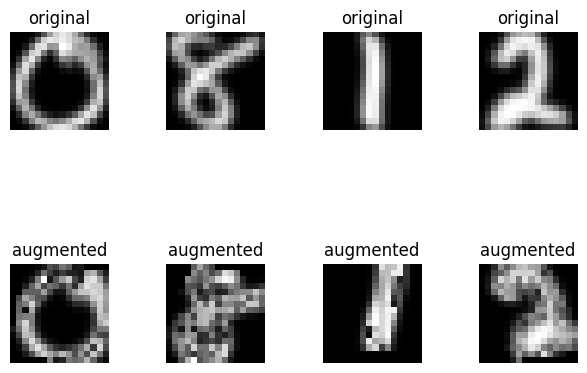

In [20]:
dataset = load_usps()
data = dataset["data"] 
labels = dataset["target"]

# usps data from paper normalized to [~-1,~1]

from scipy.io import loadmat
data_mat = loadmat("./practical/DeepClustering/DeepECT/usps_resampled.mat")
data = np.concatenate([data_mat['train_patterns'].T, data_mat['test_patterns'].T], 0)
labels = np.argmax(np.concatenate([data_mat['train_labels'].T, data_mat['test_labels'].T], 0), 1)
print(np.min(data))
show_augmented_data(data, DatasetType.USPS, (16,16), 4)

##### FMNIST

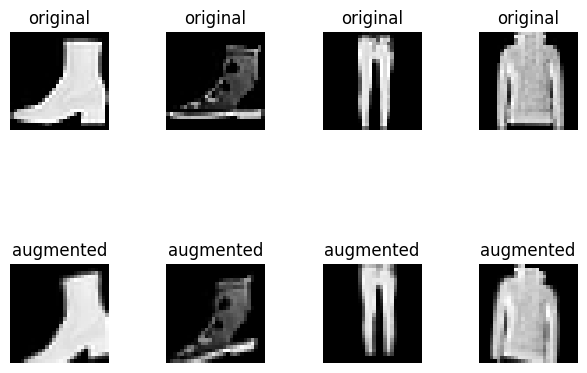

In [5]:
dataset = load_fmnist()
data = dataset["data"] / 255
labels = dataset["target"]
show_augmented_data(data, DatasetType.FASHION_MNIST, (28,28), 4)

# Evaluation

Set multiple Seeds here

In [11]:
seeds = [21, 42]

#### MNIST

In [12]:
flat_mnist_multiple_seeds_clustpy_ae, hierarchical_mnist_multiple_seeds_clustpy_ae = evaluate_multiple_seeds(
    autoencoder_type=AutoencoderType.CLUSTPY_STANDARD,
    dataset_type=DatasetType.MNIST,
    seeds=seeds,
)

flat_mnist_multiple_seeds_stacked_ae, hierarchical_mnist_multiple_seeds_stacked_ae = evaluate_multiple_seeds(
    autoencoder_type=AutoencoderType.DEEPECT_STACKED_AE,
    dataset_type=DatasetType.MNIST,
    seeds=seeds,
)

mean_flat_mnist = calculate_flat_mean_for_multiple_seeds(pd.concat([flat_mnist_multiple_seeds_clustpy_ae, flat_mnist_multiple_seeds_stacked_ae], ignore_index=True))
mean_hierarchical_mnist = calculate_hierarchical_mean_for_multiple_seeds(
    pd.concat(
        [flat_mnist_multiple_seeds_clustpy_ae, flat_mnist_multiple_seeds_stacked_ae, hierarchical_mnist_multiple_seeds_clustpy_ae, hierarchical_mnist_multiple_seeds_stacked_ae], ignore_index=True
    )
)

-------------------------------------------Run: MNIST_CLUSTPY_STANDARD_10_21
-------------------------------------------Time needed: 0.00025156666666666664min
-------------------------------------------Run: MNIST_CLUSTPY_STANDARD_10_42
-------------------------------------------Time needed: 4.52e-05min
-------------------------------------------Run: MNIST_DEEPECT_STACKED_AE_10_21
-------------------------------------------Time needed: 4.3100000000000004e-05min
-------------------------------------------Run: MNIST_DEEPECT_STACKED_AE_10_42
-------------------------------------------Time needed: 4.243333333333333e-05min


#### USPS

In [13]:
flat_usps_multiple_seeds_clustpy_ae, hierarchical_usps_multiple_seeds_clustpy_ae = evaluate_multiple_seeds(
    autoencoder_type=AutoencoderType.CLUSTPY_STANDARD,
    dataset_type=DatasetType.USPS,
    seeds=seeds,
)

flat_usps_multiple_seeds_stacked_ae, hierarchical_usps_multiple_seeds_stacked_ae = evaluate_multiple_seeds(
    autoencoder_type=AutoencoderType.DEEPECT_STACKED_AE,
    dataset_type=DatasetType.USPS,
    seeds=seeds,
)

mean_flat_usps = calculate_flat_mean_for_multiple_seeds(pd.concat([flat_usps_multiple_seeds_clustpy_ae, flat_usps_multiple_seeds_stacked_ae], ignore_index=True))
mean_hierarchical_usps = calculate_hierarchical_mean_for_multiple_seeds(
    pd.concat([flat_usps_multiple_seeds_clustpy_ae, flat_usps_multiple_seeds_stacked_ae, hierarchical_usps_multiple_seeds_clustpy_ae, hierarchical_usps_multiple_seeds_stacked_ae], ignore_index=True)
)

-------------------------------------------Run: USPS_CLUSTPY_STANDARD_10_21
-------------------------------------------Time needed: 7.228333333333333e-05min
-------------------------------------------Run: USPS_CLUSTPY_STANDARD_10_42
-------------------------------------------Time needed: 4.841666666666667e-05min
-------------------------------------------Run: USPS_DEEPECT_STACKED_AE_10_21
-------------------------------------------Time needed: 0.034680716666666674min
-------------------------------------------Run: USPS_DEEPECT_STACKED_AE_10_42
-------------------------------------------Time needed: 0.022330216666666666min


#### FASHION MNIST

In [14]:
flat_fashion_multiple_seeds_clustpy_ae, hierarchical_fashion_multiple_seeds_clustpy_ae = (
    evaluate_multiple_seeds(
        autoencoder_type=AutoencoderType.CLUSTPY_STANDARD,
        dataset_type=DatasetType.FASHION_MNIST,
        seeds=seeds,
    )
)

flat_fashion_multiple_seeds_stacked_ae, hierarchical_fashion_multiple_seeds_stacked_ae = (
    evaluate_multiple_seeds(
        autoencoder_type=AutoencoderType.DEEPECT_STACKED_AE,
        dataset_type=DatasetType.FASHION_MNIST,
        seeds=seeds,
    )
)

mean_flat_fashion = calculate_flat_mean_for_multiple_seeds(pd.concat([flat_fashion_multiple_seeds_clustpy_ae, flat_fashion_multiple_seeds_stacked_ae], ignore_index=True))
mean_hierarchical_fashion = calculate_hierarchical_mean_for_multiple_seeds(
    pd.concat(
        [hierarchical_fashion_multiple_seeds_clustpy_ae, hierarchical_fashion_multiple_seeds_stacked_ae, flat_fashion_multiple_seeds_clustpy_ae, flat_fashion_multiple_seeds_stacked_ae],
        ignore_index=True,
    )
)

-------------------------------------------Run: FASHION_MNIST_CLUSTPY_STANDARD_10_21
-------------------------------------------Time needed: 6.583333333333334e-05min
-------------------------------------------Run: FASHION_MNIST_CLUSTPY_STANDARD_10_42
-------------------------------------------Time needed: 4.823333333333333e-05min
-------------------------------------------Run: FASHION_MNIST_DEEPECT_STACKED_AE_10_21
-------------------------------------------Time needed: 4.794999999999999e-05min
-------------------------------------------Run: FASHION_MNIST_DEEPECT_STACKED_AE_10_42
-------------------------------------------Time needed: 4.44e-05min


#### REUTERS

In [15]:
flat_reuters_multiple_seeds_clustpy_ae, hierarchical_reuters_multiple_seeds_clustpy_ae = (
    evaluate_multiple_seeds(
        autoencoder_type=AutoencoderType.CLUSTPY_STANDARD,
        dataset_type=DatasetType.REUTERS,
        seeds=seeds,
    )
)

flat_reuters_multiple_seeds_stacked_ae, hierarchical_reuters_multiple_seeds_stacked_ae = (
    evaluate_multiple_seeds(
        autoencoder_type=AutoencoderType.DEEPECT_STACKED_AE,
        dataset_type=DatasetType.REUTERS,
        seeds=seeds,
    )
)

mean_flat_reuters = calculate_flat_mean_for_multiple_seeds(pd.concat([flat_reuters_multiple_seeds_clustpy_ae, flat_reuters_multiple_seeds_stacked_ae], ignore_index=True))
mean_hierarchical_reuters = calculate_hierarchical_mean_for_multiple_seeds(
    pd.concat(
        [flat_reuters_multiple_seeds_clustpy_ae, flat_reuters_multiple_seeds_stacked_ae, hierarchical_reuters_multiple_seeds_clustpy_ae, hierarchical_reuters_multiple_seeds_stacked_ae],
        ignore_index=True,
    )
)

-------------------------------------------Run: REUTERS_CLUSTPY_STANDARD_10_21
-------------------------------------------Time needed: 0.00010451666666666665min
-------------------------------------------Run: REUTERS_CLUSTPY_STANDARD_10_42
-------------------------------------------Time needed: 7.814999999999999e-05min
-------------------------------------------Run: REUTERS_DEEPECT_STACKED_AE_10_21
-------------------------------------------Time needed: 0.1822497min
-------------------------------------------Run: REUTERS_DEEPECT_STACKED_AE_10_42
-------------------------------------------Time needed: 0.1743674min


## Flat Clustering

In [16]:
flat_combined_df = pd.concat([mean_flat_mnist, mean_flat_usps, mean_flat_fashion, mean_flat_reuters], ignore_index=True)
# Pivot the DataFrame to match the desired format
pivot_df = flat_combined_df.pivot(index=['method', 'autoencoder'], columns='dataset', values=['nmi', 'acc', 'ari',])

# Reorder the columns to match the order in the image
pivot_df = pivot_df.reindex(columns=[('nmi', DatasetType.MNIST.value), ('acc', DatasetType.MNIST.value), ('ari', DatasetType.MNIST.value),
                                     ('nmi', DatasetType.USPS.value), ('acc', DatasetType.USPS.value), ('ari', DatasetType.USPS.value),
                                     ('nmi', DatasetType.FASHION_MNIST.value), ('acc', DatasetType.FASHION_MNIST.value), ('ari', DatasetType.FASHION_MNIST.value),
                                     ('nmi', DatasetType.REUTERS.value), ('acc', DatasetType.REUTERS.value), ('ari', DatasetType.REUTERS.value)])


# For Jupyter Notebook display with better formatting
pivot_df.style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#f7f7f9'), 
                                       ('color', '#333'), 
                                       ('border', '1px solid #ddd')]},
    {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#f9f9f9'), ('color', '#333')]},
    {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#fff'), ('color', '#333') ]}
]).set_caption("Flat Clustering results")

## Hierarchical Clustering

In [17]:
hierarchical_combined = pd.concat(
    [
        mean_hierarchical_mnist,
        mean_hierarchical_usps,
        mean_hierarchical_fashion,
        mean_hierarchical_reuters,
    ],
    ignore_index=True,
)
# Pivot the DataFrame to match the desired format
pivot_df = hierarchical_combined.pivot(
    index=["method", "autoencoder"], columns="dataset", values=["dp", "lp"]
)

# Reorder the columns to match the order in the image
pivot_df = pivot_df.reindex(columns=[('dp', DatasetType.MNIST.value), ('lp', DatasetType.MNIST.value), 
                                     ('dp', DatasetType.USPS.value), ('lp', DatasetType.USPS.value),
                                     ('dp', DatasetType.FASHION_MNIST.value), ('lp', DatasetType.FASHION_MNIST.value),
                                     ('dp', DatasetType.REUTERS.value), ('lp', DatasetType.REUTERS.value)])


# For Jupyter Notebook display with better formatting
pivot_df.style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#f7f7f9'), 
                                       ('color', '#333'), 
                                       ('border', '1px solid #ddd')]},
    {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#f9f9f9'), ('color', '#333')]},
    {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#fff'), ('color', '#333') ]}
]).set_caption("Hierarchical Clustering results")

# Visualization of DeepECT Cluster Tree

In [ ]:
from practical.DeepClustering.DeepECT.evaluation_pipeline import get_dataset
import practical.DeepClustering.DeepECT.deepect_adjusted as deepect_paper
def graphviz_layout_binary_tree(G, root):
    A = nx.nx_agraph.to_agraph(G)
    A.layout(prog='dot')  # 'dot' is used for hierarchical layouts
    pos = {}
    for node in G.nodes():
        x, y = A.get_node(node).attr['pos'].split(',')
        pos[node] = (float(x), float(y))
    return pos

def build_and_visualize_tree(root, autoencoder, dataset_type):
    if root is None:
        return

    # Create a directed graph
    G = nx.DiGraph()
    
    # Helper function to add nodes and edges to the graph
    def add_edges(G, node):
        if node.left_child:
            G.add_edge(node, node.left_child)
            add_edges(G, node.left_child)
        if node.right_child:
            G.add_edge(node, node.right_child)
            add_edges(G, node.right_child)
    
    # Add nodes and edges starting from the root
    add_edges(G, root)

    # Create a position dictionary for the nodes
    pos = graphviz_layout_binary_tree(G, root)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 15))
    nx.draw(G, pos, ax=ax, with_labels=False)
    
    # Draw the images at the nodes
    for node in G.nodes:
        center = torch.from_numpy(np.expand_dims(node.center, axis=0))
        
        image = autoencoder.decode(center).detach().numpy()
        
        if dataset_type == DatasetType.USPS:
            image = image.reshape(16,16)
        else:
            image = image.reshape(28,28)
        imagebox = OffsetImage(image, zoom=1)
        ab = AnnotationBbox(imagebox, pos[node], frameon=False)
        ax.add_artist(ab)
    
    plt.show()

def visualize_cluster_tree(dataset_type: DatasetType, autoencoder_type: AutoencoderType):
    dataset = get_dataset(dataset_type)

    data = dataset["data"]
    labels = dataset["target"]

    autoencoder = pretraining(autoencoder_type, None, dataset, 42, 10)

    deepect = deepect_paper.DeepECT(
        autoencoder=autoencoder,
        clustering_optimizer_params={"lr": 1e-4, "betas": (0.9, 0.999)},
        max_leaf_nodes=20,
        random_state=np.random.RandomState(42),
    )

    deepect.fit(data)

    print("Accuracy: ", deepect.tree_.flat_accuracy(labels, 10))

    build_and_visualize_tree(deepect.tree_.root, autoencoder, dataset_type)

cpu


Fit:   1%|          | 503/50000 [00:35<10:55:26,  1.26it/s]

Leaf assignments: 48732
Tree size after growing: 5, leaf nodes: 3


Fit:   2%|▏         | 1002/50000 [01:18<11:34:03,  1.18it/s]

Leaf assignments: 30922
Tree size after growing: 7, leaf nodes: 4


Fit:   3%|▎         | 1503/50000 [01:53<8:02:20,  1.68it/s] 

Leaf assignments: 20642
Tree size after growing: 9, leaf nodes: 5


Fit:   4%|▍         | 2001/50000 [02:30<13:41:09,  1.03s/it]

Leaf assignments: 15744
Tree size after growing: 11, leaf nodes: 6


Fit:   5%|▌         | 2503/50000 [03:09<8:05:38,  1.63it/s] 

Leaf assignments: 18325
Tree size after growing: 13, leaf nodes: 7


Fit:   6%|▌         | 3003/50000 [03:45<7:48:57,  1.67it/s] 

Leaf assignments: 12913
Tree size after growing: 15, leaf nodes: 8


Fit:   7%|▋         | 3503/50000 [04:22<8:05:38,  1.60it/s] 

Leaf assignments: 9879
Tree size after growing: 17, leaf nodes: 9


Fit:   8%|▊         | 4003/50000 [04:59<7:56:07,  1.61it/s] 

Leaf assignments: 12646
Tree size after growing: 19, leaf nodes: 10


Fit:   9%|▉         | 4502/50000 [05:41<14:23:08,  1.14s/it]

Leaf assignments: 5861
Tree size after growing: 21, leaf nodes: 11


Fit:  10%|█         | 5001/50000 [06:27<13:58:02,  1.12s/it]

Leaf assignments: 6452
Tree size after growing: 23, leaf nodes: 12


Fit:  11%|█         | 5501/50000 [07:14<14:01:26,  1.13s/it]

Leaf assignments: 7400
Tree size after growing: 25, leaf nodes: 13


Fit:  12%|█▏        | 6001/50000 [08:02<16:06:46,  1.32s/it]

Leaf assignments: 7024
Tree size after growing: 27, leaf nodes: 14


Fit:  13%|█▎        | 6502/50000 [08:51<13:26:08,  1.11s/it]

Leaf assignments: 6431
Tree size after growing: 29, leaf nodes: 15


Fit:  14%|█▍        | 7001/50000 [09:38<13:47:11,  1.15s/it]

Leaf assignments: 6723
Tree size after growing: 31, leaf nodes: 16


Fit:  15%|█▌        | 7501/50000 [10:25<13:12:17,  1.12s/it]

Leaf assignments: 5638
Tree size after growing: 33, leaf nodes: 17


Fit:  16%|█▌        | 8002/50000 [11:13<13:09:13,  1.13s/it]

Leaf assignments: 5091
Tree size after growing: 35, leaf nodes: 18


Fit:  17%|█▋        | 8501/50000 [12:00<12:56:47,  1.12s/it]

Leaf assignments: 6616
Tree size after growing: 37, leaf nodes: 19


Fit:  18%|█▊        | 9002/50000 [12:45<9:55:29,  1.15it/s] 

Leaf assignments: 9065
Tree size after growing: 39, leaf nodes: 20


Predict: 100%|██████████| 274/274 [00:02<00:00, 97.10it/s]


Accuracy:  0.8468571428571429


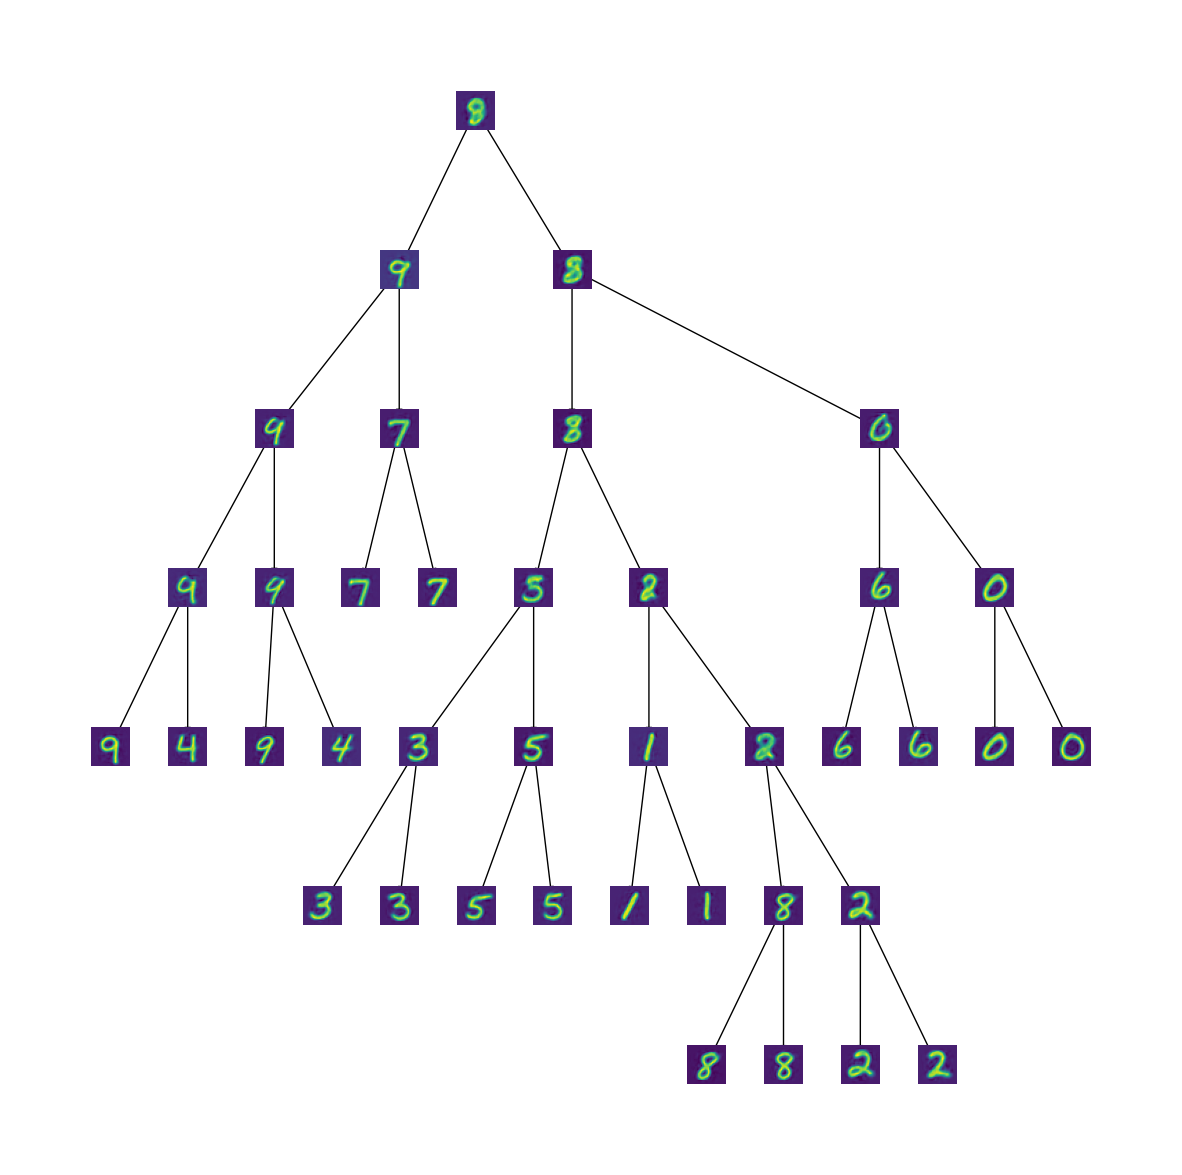

In [ ]:
visualize_cluster_tree(
    DatasetType.MNIST, AutoencoderType.CLUSTPY_STANDARD
), visualize_cluster_tree(DatasetType.MNIST, AutoencoderType.DEEPECT_STACKED_AE)

#### Visualize embedded space after DeepECT

Autoencoder parameters loaded from file.


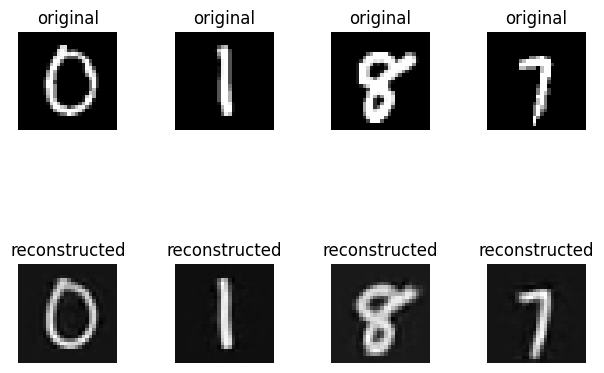

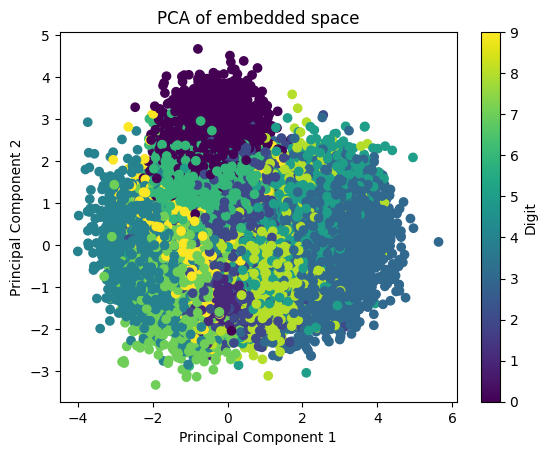

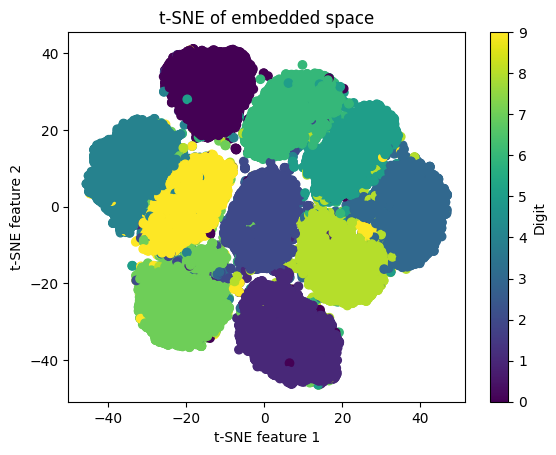

In [4]:
dataset = load_mnist()
dataset["data"] = dataset["data"] * 0.02
data = dataset["data"]
labels = dataset["target"]
visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/results_autoencoder/MNIST_CLUSTPY_STANDARD_10_DEEPECT_PAPER_21.pt",
    AutoencoderType.CLUSTPY_STANDARD,
    dataset,
    (28, 28),
    4,
    seed=21,
)

In [61]:
import pandas as pd
import re
import matplotlib.pyplot as plt
def loss_visual(file_path:str):
    steps = []
    dc_loss = []
    nc_loss = []
    rec_loss = []
    rec_loss_aug = []
    total_loss = []
    pattern = re.compile(r"INFO:root:(\d+) - moving averages: dc_loss: ([\d.]+) nc_loss: ([\d.]+) rec_loss: ([\d.]+) rec_loss_aug: ([\d.]+) total_loss: ([\d.]+)")

    with open(file_path,'r') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                steps.append(int(match.group(1)))
                dc_loss.append(float(match.group(2)))
                nc_loss.append(float(match.group(3)))
                rec_loss.append(float(match.group(4)))
                rec_loss_aug.append(float(match.group(5)))
                total_loss.append(float(match.group(6)))

    df = pd.DataFrame({
        'step':steps,
        'DC Loss':dc_loss,
        'NC Loss':nc_loss,
        'Rec Loss': rec_loss,
        'Rec Loss Aug': rec_loss_aug,
        'Total Loss': total_loss
    })
    return df

KeyError: 'Rec Loss aug'

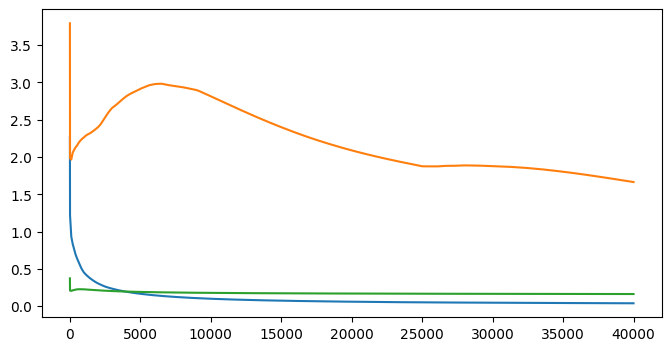

In [63]:
file_path = '/Users/yy/LMU_Master_Practical_SoSe24/practical/DeepClustering/DeepECT/results_log/MNIST_CLUSTPY_STANDARD_10_DEEPECT_AUGMENTED_PAPER_21.txt'
df = loss_visual(file_path)
plt.figure(figsize=(8,4))
plt.plot(df['step'], df['DC Loss'], label='DC ')
plt.plot(df['step'], df['NC Loss'], label='NC ')
plt.plot(df['step'], df['Rec Loss'], label='Rec Loss ')
plt.plot(df['step'], df['Rec Loss Aug'], label='Rec Loss augmentated')
plt.plot(df['step'], df['Total Loss'], label='Total Loss ')
plt.ylabel('Loss')
plt.title('Loss with pretrained standard autoencoder on MNIST from paper')
plt.legend()
plt.grid(True)
plt.show()



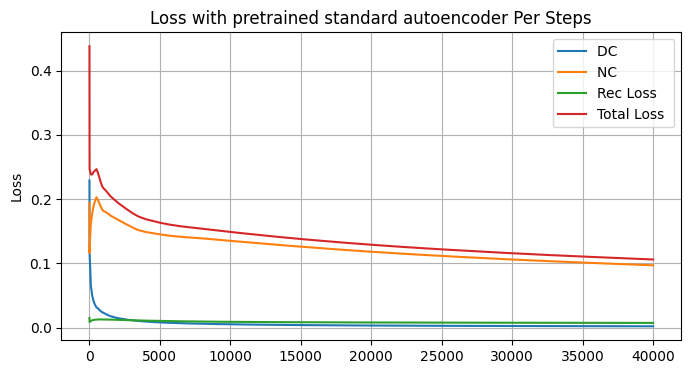

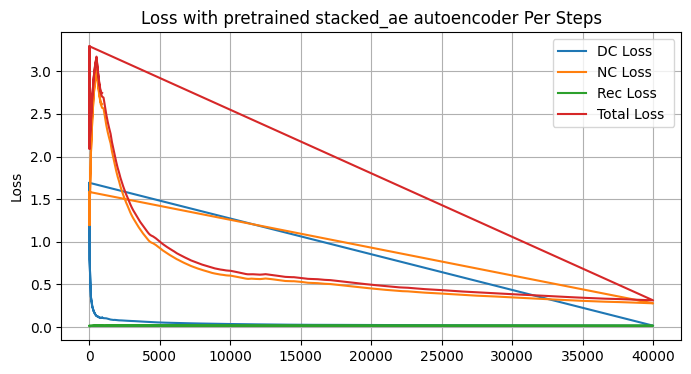

In [16]:

file_path = 'practical/DeepClustering/DeepECT/loss/MNIST_loss.log'
df = loss_visual(file_path)
plt.figure(figsize=(8,4))
plt.plot(df['step'], df['DC Loss'], label='DC ')
plt.plot(df['step'], df['NC Loss'], label='NC ')
plt.plot(df['step'], df['Rec Loss'], label='Rec Loss ')
plt.plot(df['step'], df['Total Loss'], label='Total Loss ')
plt.ylabel('Loss')
plt.title('Loss with pretrained standard autoencoder Per Steps')
plt.legend()
plt.grid(True)
plt.show()
file_path = 'practical/DeepClustering/DeepECT/loss/MNIST_stacked_ae_loss.log'
df = loss_visual(file_path)
plt.figure(figsize=(8,4))
plt.plot(df['step'], df['DC Loss'], label='DC Loss ')
plt.plot(df['step'], df['NC Loss'], label='NC Loss ')
plt.plot(df['step'], df['Rec Loss'], label='Rec Loss ')
plt.plot(df['step'], df['Total Loss'], label='Total Loss ')
plt.ylabel('Loss')
plt.title('Loss with pretrained stacked_ae autoencoder Per Steps')
plt.legend()
plt.grid(True)
plt.show()

cpu


Fit:   1%|          | 503/50000 [00:37<8:45:16,  1.57it/s] 

Leaf assignments: 46556
Tree size after growing: 5, leaf nodes: 3


Fit:   2%|▏         | 1002/50000 [01:11<10:59:45,  1.24it/s]

Leaf assignments: 22235
Tree size after growing: 7, leaf nodes: 4


Fit:   3%|▎         | 1503/50000 [01:45<7:51:44,  1.71it/s] 

Leaf assignments: 22339
Tree size after growing: 9, leaf nodes: 5


Fit:   4%|▍         | 2002/50000 [02:18<10:41:53,  1.25it/s]

Leaf assignments: 24994
Tree size after growing: 11, leaf nodes: 6


Fit:   5%|▌         | 2502/50000 [02:52<10:12:04,  1.29it/s]

Leaf assignments: 16038
Tree size after growing: 13, leaf nodes: 7


Fit:   6%|▌         | 3002/50000 [03:25<10:36:04,  1.23it/s]

Leaf assignments: 5087
Tree size after growing: 15, leaf nodes: 8


Fit:   7%|▋         | 3503/50000 [03:58<7:26:24,  1.74it/s] 

Leaf assignments: 17650
Tree size after growing: 17, leaf nodes: 9


Fit:   8%|▊         | 4002/50000 [04:30<8:45:13,  1.46it/s]

Leaf assignments: 6445
Tree size after growing: 19, leaf nodes: 10


Fit:   9%|▉         | 4503/50000 [05:03<7:17:10,  1.73it/s] 

Leaf assignments: 9463
Tree size after growing: 21, leaf nodes: 11


Fit:  10%|█         | 5002/50000 [05:36<9:57:23,  1.26it/s]

Leaf assignments: 6257
Tree size after growing: 23, leaf nodes: 12


Fit:  11%|█         | 5503/50000 [06:14<7:53:33,  1.57it/s] 

Leaf assignments: 15138
Tree size after growing: 25, leaf nodes: 13


Fit:  12%|█▏        | 6002/50000 [06:47<9:29:19,  1.29it/s]

Leaf assignments: 8488
Tree size after growing: 27, leaf nodes: 14


Fit:  13%|█▎        | 6503/50000 [07:20<6:49:14,  1.77it/s]

Leaf assignments: 2859
Tree size after growing: 29, leaf nodes: 15


Fit:  14%|█▍        | 7001/50000 [13:30<612:26:29, 51.28s/it]

Leaf assignments: 6366
Tree size after growing: 31, leaf nodes: 16


Fit:  15%|█▌        | 7502/50000 [14:18<9:37:44,  1.23it/s]  

Leaf assignments: 2711
Tree size after growing: 33, leaf nodes: 17


Fit:  16%|█▌        | 8003/50000 [14:53<6:33:03,  1.78it/s]

Leaf assignments: 5536
Tree size after growing: 35, leaf nodes: 18


Fit:  17%|█▋        | 8503/50000 [15:29<6:43:01,  1.72it/s]

Leaf assignments: 2567
Tree size after growing: 37, leaf nodes: 19


Fit:  18%|█▊        | 9003/50000 [16:02<6:31:27,  1.75it/s]

Leaf assignments: 2414
Tree size after growing: 39, leaf nodes: 20


Predict: 100%|██████████| 274/274 [00:02<00:00, 114.17it/s]


Accuracy:  0.5767428571428571


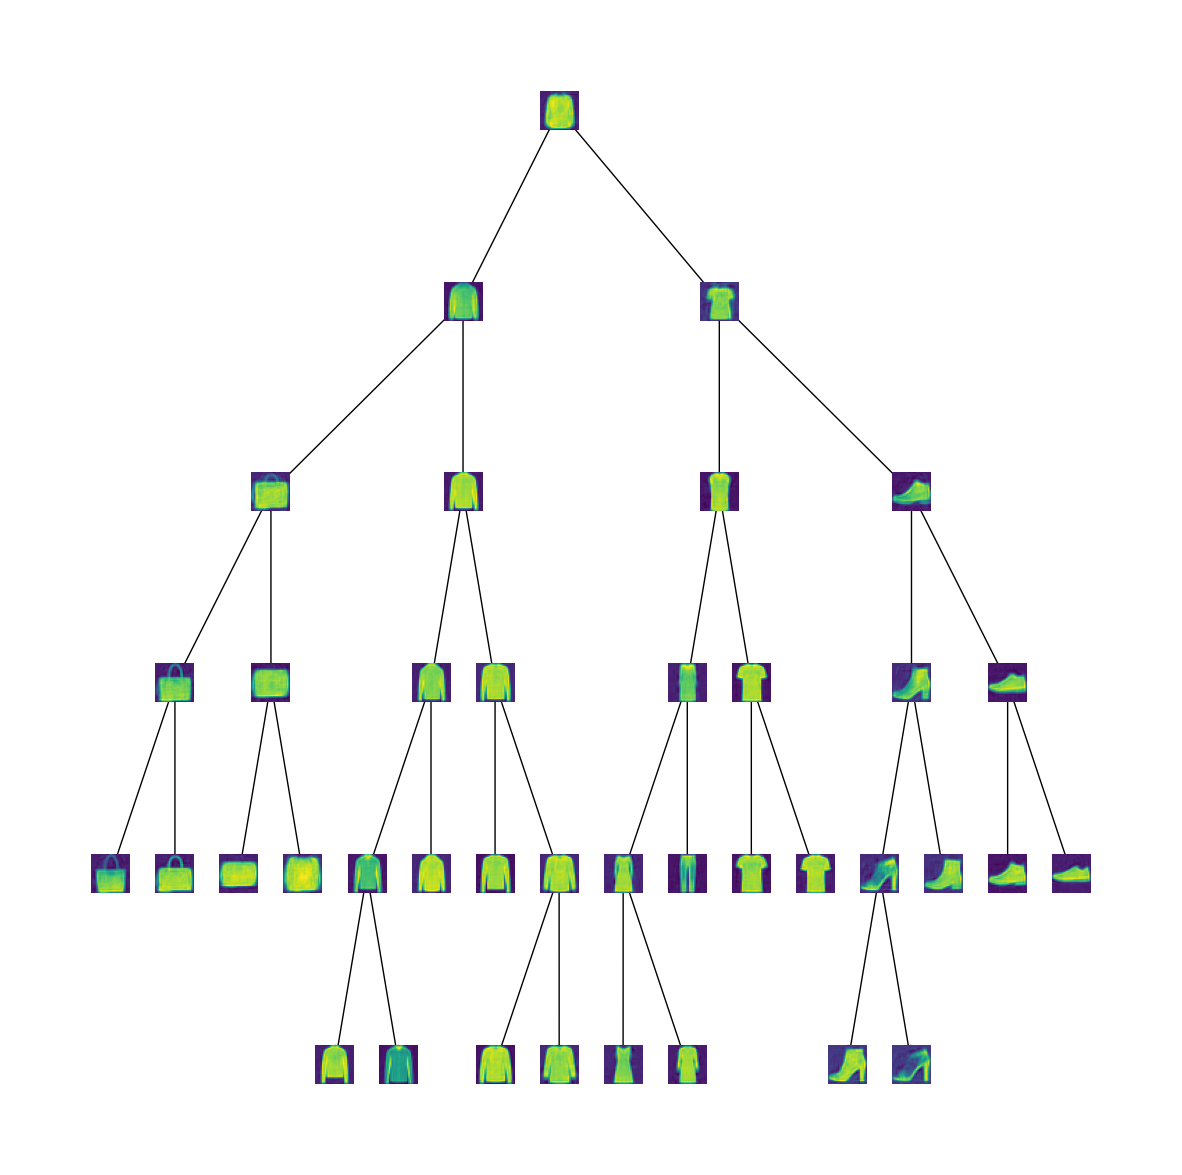

In [ ]:
visualize_cluster_tree(
    DatasetType.FASHION_MNIST, AutoencoderType.CLUSTPY_STANDARD
), visualize_cluster_tree(DatasetType.FASHION_MNIST, AutoencoderType.DEEPECT_STACKED_AE)

#### Visualize embedded space after DeepECT

Autoencoder parameters loaded from file.


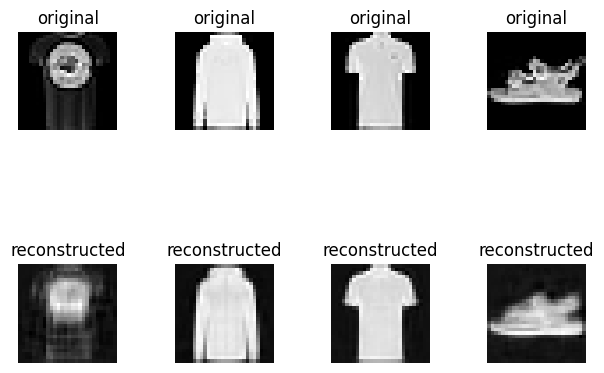

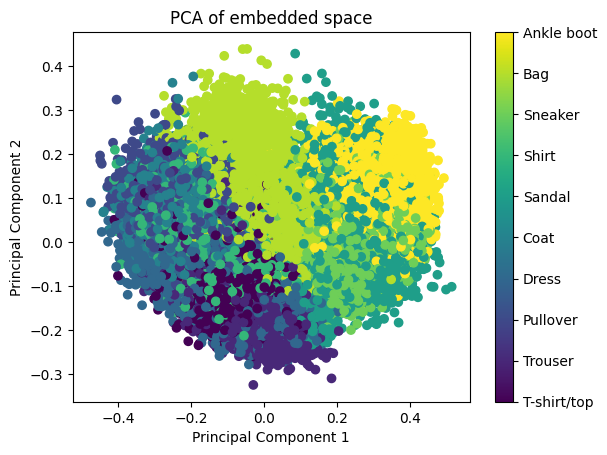

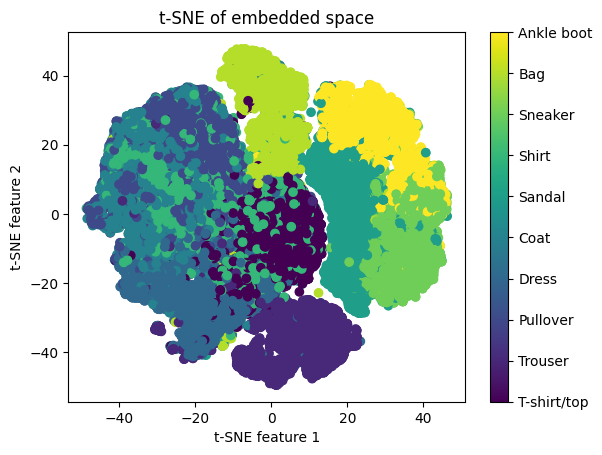

In [5]:
dataset = load_fmnist()
dataset["data"] = dataset["data"] / 255.0
data = dataset["data"] 
labels = dataset["target"]
visualize_peformance_AE(
    "practical/DeepClustering/DeepECT/results_autoencoder/FashionMNIST_CLUSTPY_STANDARD_10_DEEPECT_PAPER_21.pt",
    AutoencoderType.CLUSTPY_STANDARD,
    dataset,
    (28, 28),
    4,
    seed=21,
)

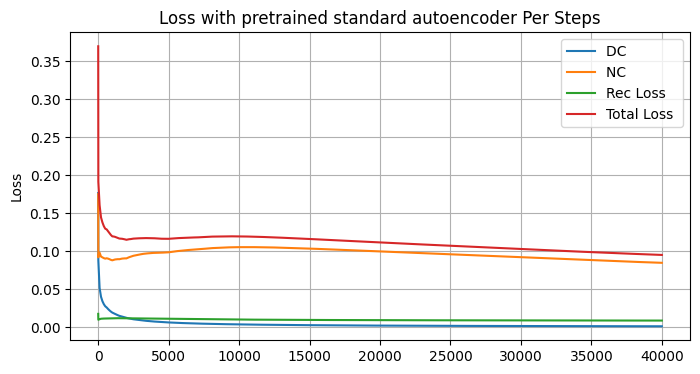

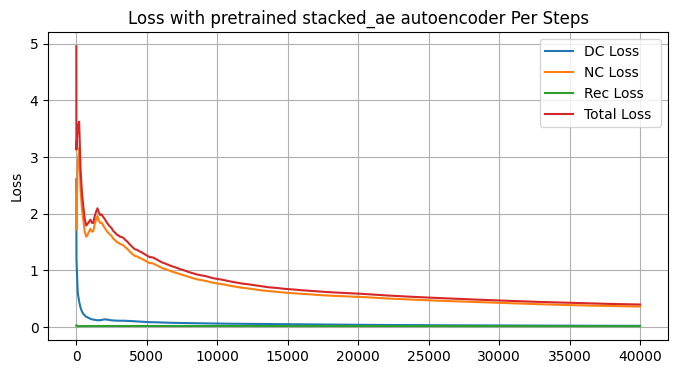

In [17]:
file_path = 'practical/DeepClustering/DeepECT/loss/FMNIST_loss.log'
df = loss_visual(file_path)
plt.figure(figsize=(8,4))
plt.plot(df['step'], df['DC Loss'], label='DC ')
plt.plot(df['step'], df['NC Loss'], label='NC ')
plt.plot(df['step'], df['Rec Loss'], label='Rec Loss ')
plt.plot(df['step'], df['Total Loss'], label='Total Loss ')
plt.ylabel('Loss')
plt.title('Loss with pretrained standard autoencoder Per Steps')
plt.legend()
plt.grid(True)
plt.show()
file_path = 'practical/DeepClustering/DeepECT/loss/FMNIST_stacked_ae_loss.log'
df = loss_visual(file_path)
plt.figure(figsize=(8,4))
plt.plot(df['step'], df['DC Loss'], label='DC Loss ')
plt.plot(df['step'], df['NC Loss'], label='NC Loss ')
plt.plot(df['step'], df['Rec Loss'], label='Rec Loss ')
plt.plot(df['step'], df['Total Loss'], label='Total Loss ')
plt.ylabel('Loss')
plt.title('Loss with pretrained stacked_ae autoencoder Per Steps')
plt.legend()
plt.grid(True)
plt.show()

cpu


Fit:   1%|          | 504/50000 [00:27<1:21:10, 10.16it/s]

Leaf assignments: 3673
Tree size after growing: 5, leaf nodes: 3


Fit:   2%|▏         | 1003/50000 [00:52<1:20:40, 10.12it/s]

Leaf assignments: 5678
Tree size after growing: 7, leaf nodes: 4


Fit:   3%|▎         | 1503/50000 [01:17<1:18:44, 10.26it/s]

Leaf assignments: 4542
Tree size after growing: 9, leaf nodes: 5


Fit:   4%|▍         | 2003/50000 [01:43<1:27:22,  9.16it/s]

Leaf assignments: 2270
Tree size after growing: 11, leaf nodes: 6


Fit:   5%|▌         | 2504/50000 [02:08<1:18:44, 10.05it/s]

Leaf assignments: 1531
Tree size after growing: 13, leaf nodes: 7


Fit:   6%|▌         | 3002/50000 [02:35<1:30:42,  8.64it/s]

Leaf assignments: 2101
Tree size after growing: 15, leaf nodes: 8


Fit:   7%|▋         | 3503/50000 [03:03<1:34:40,  8.19it/s]

Leaf assignments: 785
Tree size after growing: 17, leaf nodes: 9


Fit:   8%|▊         | 4003/50000 [03:31<1:31:32,  8.37it/s]

Leaf assignments: 1037
Tree size after growing: 19, leaf nodes: 10


Fit:   9%|▉         | 4503/50000 [03:59<1:25:33,  8.86it/s]

Leaf assignments: 1349
Tree size after growing: 21, leaf nodes: 11


Fit:  10%|█         | 5002/50000 [04:27<2:04:26,  6.03it/s]

Leaf assignments: 671
Tree size after growing: 23, leaf nodes: 12


Fit:  11%|█         | 5503/50000 [04:56<1:34:26,  7.85it/s]

Leaf assignments: 967
Tree size after growing: 25, leaf nodes: 13


Fit:  12%|█▏        | 6003/50000 [05:27<1:37:35,  7.51it/s]

Leaf assignments: 866
Tree size after growing: 27, leaf nodes: 14


Fit:  13%|█▎        | 6503/50000 [05:57<1:28:44,  8.17it/s]

Leaf assignments: 1173
Tree size after growing: 29, leaf nodes: 15


Fit:  14%|█▍        | 7003/50000 [06:25<1:26:38,  8.27it/s]

Leaf assignments: 657
Tree size after growing: 31, leaf nodes: 16


Fit:  15%|█▌        | 7502/50000 [06:54<1:47:55,  6.56it/s]

Leaf assignments: 405
Tree size after growing: 33, leaf nodes: 17


Fit:  16%|█▌        | 8003/50000 [07:24<1:38:16,  7.12it/s]

Leaf assignments: 388
Tree size after growing: 35, leaf nodes: 18


Fit:  17%|█▋        | 8503/50000 [07:53<1:27:17,  7.92it/s]

Leaf assignments: 457
Tree size after growing: 37, leaf nodes: 19


Fit:  18%|█▊        | 9002/50000 [08:22<1:43:20,  6.61it/s]

Leaf assignments: 729
Tree size after growing: 39, leaf nodes: 20


Predict: 100%|██████████| 37/37 [00:00<00:00, 110.28it/s]


Accuracy:  0.6300279630027963


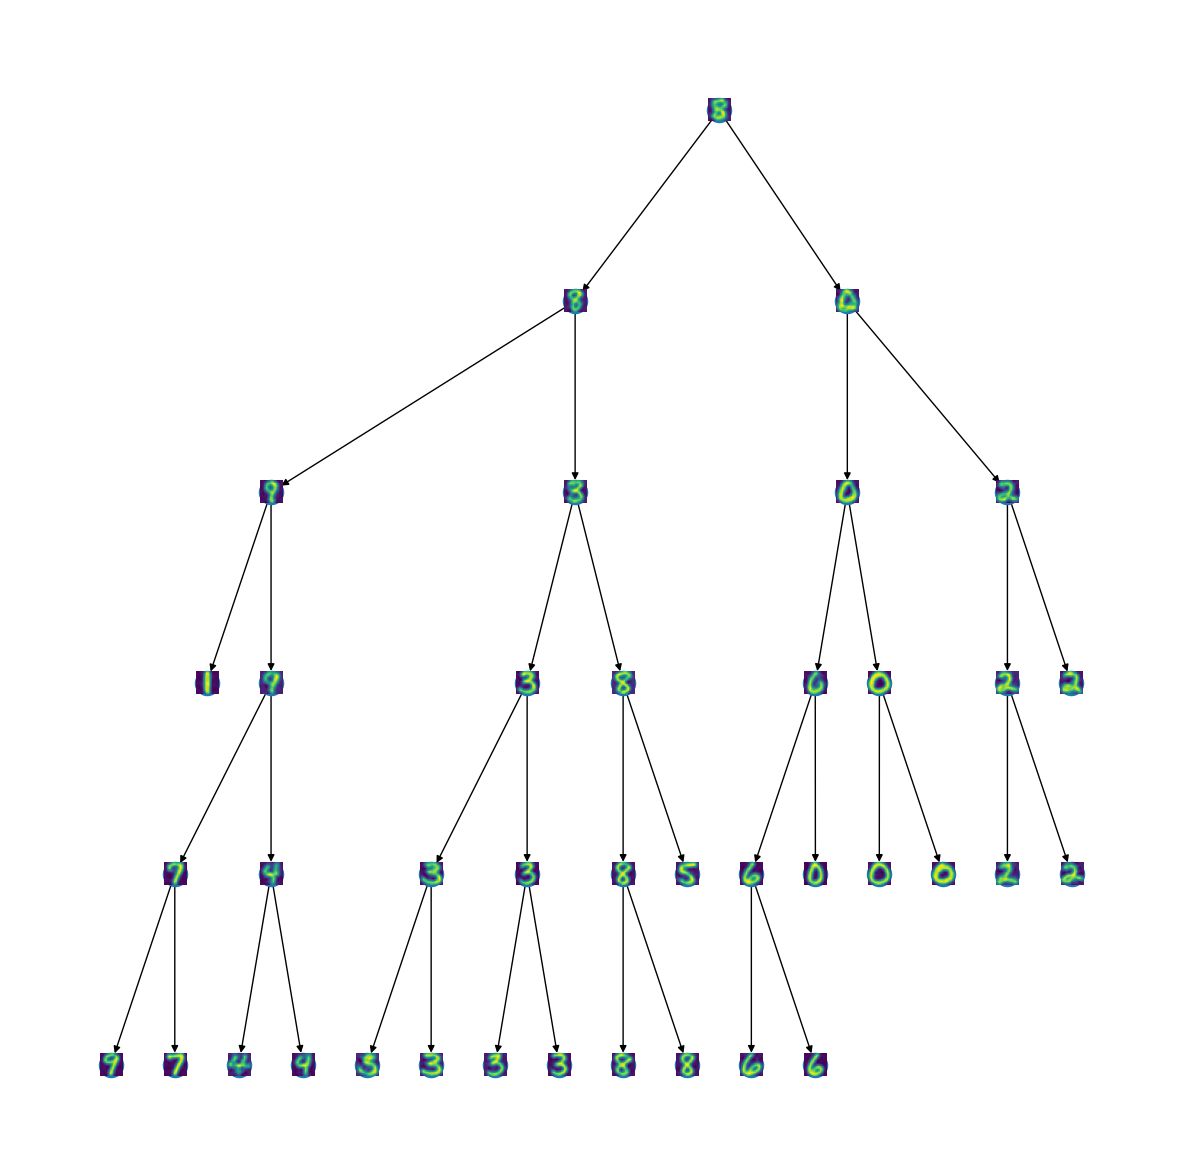

In [ ]:
visualize_cluster_tree(
    DatasetType.USPS, AutoencoderType.CLUSTPY_STANDARD
), visualize_cluster_tree(DatasetType.USPS, AutoencoderType.DEEPECT_STACKED_AE)

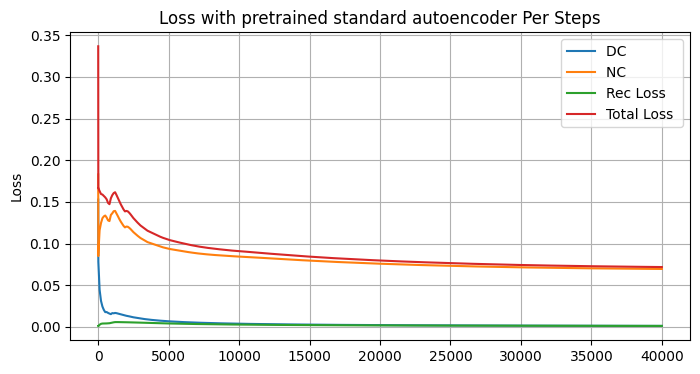

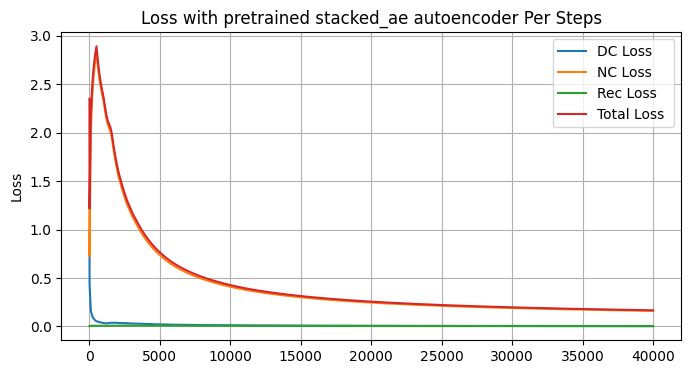

In [18]:
file_path = 'practical/DeepClustering/DeepECT/loss/USPs_loss.log'
df = loss_visual(file_path)
plt.figure(figsize=(8,4))
plt.plot(df['step'], df['DC Loss'], label='DC ')
plt.plot(df['step'], df['NC Loss'], label='NC ')
plt.plot(df['step'], df['Rec Loss'], label='Rec Loss ')
plt.plot(df['step'], df['Total Loss'], label='Total Loss ')
plt.ylabel('Loss')
plt.title('Loss with pretrained standard autoencoder Per Steps')
plt.legend()
plt.grid(True)
plt.show()
file_path = 'practical/DeepClustering/DeepECT/loss/USPs_stacked_ae_loss.log'
df = loss_visual(file_path)
plt.figure(figsize=(8,4))
plt.plot(df['step'], df['DC Loss'], label='DC Loss ')
plt.plot(df['step'], df['NC Loss'], label='NC Loss ')
plt.plot(df['step'], df['Rec Loss'], label='Rec Loss ')
plt.plot(df['step'], df['Total Loss'], label='Total Loss ')
plt.ylabel('Loss')
plt.title('Loss with pretrained stacked_ae autoencoder Per Steps')
plt.legend()
plt.grid(True)
plt.show()